<a href="https://colab.research.google.com/github/Nytilde/Edda-MLDifficultyPredictor/blob/main/MLDifficultyPredictorII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLDifficultyPredictor II
## Introduction
The aim of this jupyter notebook is to use exploratory data analysis (EDA) to optimize the existing features of the first difficulty prediction Model by PKBeam and to identify additional features. By conducting an EDA, the underlying patterns, trends and correlations in the data are to be discovered in order to create a sound basis for improving the existing features and to identify potentially relevant new features.

The goal is to increase the quality of the model through optimized feature selection and construction, leading to improved predictions and a better understanding of the underlying data.

## Setup
To run this notebook, click on the "Run with Colab" icon to import this exported environment to Google Colab and execute it in real-time.

To utilize the external libraries required for exporting ONNX and PMML files, it is recommended to host the runtime locally via a Docker instance. For a more detailed description, please refer to the following link: https://research.google.com/colaboratory/local-runtimes.html

Alternatively, you can also utilize other common Jupyter runtime environments for execution.

## ToDo
 - [x] rework of get_max_time() to determine the range between first and last time instead


 - [x] Calculate vector of time difference Δt (change rate)
  - [x] the average time difference
  - [x] longest break (maybe linear dependency)
  - [x] double notes (change rate = 0)
  - [x] longest low time periode
  - [x] inspect quantil range
  - [ ] amount of breaks within a time window (rolling window with Δt max)
  - [ ] any ideas?


 - [x] NoteDensity with Δt > 1 (rolling window)
  - [ ] inspect quantil range
  - [ ] inspect window size


 - [ ] add NPS (used in EDDA) as feature


 - [ ] Find and count "hard to play patterns" (method 1):
  - [ ] define and match pattern by using a frequence (e.g. 1, 2, 3, 4, 3, 2, 1)
  - [ ] always check if it is a double note (if time is equal)
  - [ ] define a weight to each pattern
  - [ ] add a threshold value for the time difference between each note within the pattern
  - [ ] count each weight
  (if there is no use here, maybe we can add this also to EDDA)


 - [ ] Find and count "hard to play patterns" using unsupervised learning (method 2):


 - [ ] Consider all BpmChanges and their duration, instead of using only the defined BPM.



# Import

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import json
import os
import csv
import random
import seaborn as sns
import scipy.stats as stats
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVR, SVC
from collections import Counter

original Methods from PKBeam

In [ ]:
def getMapDataForPath(path):
    mapDataName = ""
    if "info.dat" in os.listdir(f"{path}"):
        mapDataName = "info.dat"
    if "Info.dat" in os.listdir(f"{path}"):
        mapDataName = "Info.dat"
    with open(f"{path}/{mapDataName}", "r") as f:
        mapData = f.read()
        mapJson = json.loads(mapData)
        return mapJson

def getMapData(mapFolder, folder):
    return getMapDataForPath(f"{mapFolder}/{folder}")

def getDifficultyMapsForPath(path):
    difficultyMaps = []
    mapJson = getMapDataForPath(path)
    for d in mapJson["_difficultyBeatmapSets"][0]["_difficultyBeatmaps"]:
        difficultyMaps.append((d["_beatmapFilename"], d["_difficultyRank"]))
    return difficultyMaps

def getDifficultyMaps(mapFolder, folder):
    return getDifficultyMapsForPath(f"{mapFolder}/{folder}")

def getDifficultyMapDataForPath(path, file):
    filePath = f"{path}/{file}"
    with open(filePath, "r") as f:
        mapData = f.read()
        mapJson = json.loads(mapData)
        return mapJson

def getDifficultyMapData(mapFolder, folder, file):
    return getDifficultyMapDataForPath(f"{mapFolder}/{folder}", file)

def getMaps(mapFolder):
    maps = []
    for obj in os.listdir(f"{mapFolder}"):
        objPath = f"{mapFolder}/{obj}"
        if os.path.isdir(objPath) and ("info.dat" in os.listdir(objPath) or "Info.dat" in os.listdir(objPath)):
            maps.append(obj)
    return maps

def beatToSec(beat, bpm):
    return 60/bpm * beat

# def getNoteDensity(diffMapData, duration):
#     notesList = diffMapData["_notes"]
#     return len(notesList)/duration

# heuristically, windowLength = 2.75, step = 0.25 is best
# def getLocalNoteDensities(time_array, duration, windowLength=2.75, step=0.25):
#     densities = []
#     windowLower = 0
#     windowUpper = windowLength
#     while windowUpper < duration:
#         numNotes = 0
#         for noteTime in time_array:
#             if windowLower <= noteTime and noteTime <= windowUpper:
#                 numNotes += 1
#         densities.append(numNotes/windowLength)
#         windowLower += step
#         windowUpper += step
#     return densities

# def getLocalColumnVariety(diffMapData, duration, bpm, windowLength=2.75, step=0.25):
#     variety = []
#     beatsPerWindow = bpm/60 * windowLength
#     windowLower = 0
#     windowUpper = windowLength
#     while windowUpper < duration:
#         localVariety = np.array([0, 0, 0, 0])
#         for n in diffMapData["_notes"]:
#             noteTime = beatToSec(n["_time"], bpm)
#             noteCol = n["_lineIndex"]
#             if windowUpper <= noteTime:
#                 break
#             if windowLower <= noteTime:
#                 localVariety[noteCol] += 1
#             if np.linalg.norm(localVariety, 1) > 0:
#                 # L1-normalise or normalise for the amount of notes
#                 normLocalVariety = localVariety / np.linalg.norm(localVariety, 1)
#                 # maps with higher column variety will have a distribution closer to [.25, .25, .25, .25]
#                 score = np.linalg.norm(normLocalVariety - np.array([0.25, 0.25, 0.25, 0.25]), 2)
#                 # higher is better
#                 variety.append(-1 * score)

#         windowLower += step
#         windowUpper += step
#     return variety

In [ ]:
def get_note_densitys_per_window(time_array, window_length=2.75):
    start_indices = np.searchsorted(time_array, time_array - window_length, side='left')
    end_indices = np.searchsorted(time_array, time_array + window_length, side='left')
    return (end_indices - start_indices) / window_length

def get_count_note_density_per_window(time_diff, window_length=2):
    note_counts = np.sum((time_diff >= -window_length) & (time_diff <= window_length), axis=0)
    return note_counts / window_length

def get_note_density(float_array, duration):
    return len(float_array)/duration

def extract_times_from_dicts_list(dicts_list, bpm, key='_time'):
    return np.array([beatToSec(d['_time'], bpm) for d in dicts_list])

def get_min_max_diff(float_array):
    return max(float_array) - min(float_array)

def remove_zeros(float_array, tolerance=1e-4):
    non_zero_indices = np.abs(float_array) > tolerance
    return float_array[non_zero_indices]

# deprecated
# def get_longest_low_value_sequence(time_diffs):
#     unique_values, indices, counts = np.unique(time_diffs, return_index=True, return_counts=True)
#     matrix = np.zeros((len(unique_values), len(time_diffs)), dtype=int)

#     for idx, count in zip(indices, counts):
#         val_index = np.where(unique_values == time_diffs[idx])[0][0]
#         matrix[val_index, idx:idx+count] = 1

#     row_sums = np.sum(matrix, axis=1)
#     max_density_index = np.argmax(row_sums / len(time_diffs))
#     max_density = row_sums[max_density_index] / len(time_diffs)

#     series_start = np.argmax(matrix[max_density_index])
#     series_end = len(time_diffs) - 1 - np.argmax(np.flip(matrix[max_density_index]))

#     return time_diffs[series_start:series_end+1]


def generate_leave_one_value_out_sequence(lst):
    for i, value in enumerate(lst):
         yield (lst[:i] + lst[i+1:], value)

def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data)))

def max_abs_column_name(row):
    return row.abs().idxmax()

def min_abs_column_name(row):
    return row.abs().idxmin()

def second_max_abs_column_name(row):
    return row.abs().sort_values(ascending=False).index[1]

def plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap=cmap)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)

    plt.show()

def longest_high_density_sequence(densities, threshold):
    m = np.r_[False,densities>threshold,False]
    idx = np.flatnonzero(m[:-1]!=m[1:])
    longest_subsequence_len = (idx[1::2]-idx[::2]).max(initial=0)
    return longest_subsequence_len


# Upload / Import Raw Data



you can upload a zip folder with the maps and unzip it with the following script

In [ ]:
# uploaded
import zipfile

def unzip_file(path, extract_to):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    extracted_files = os.listdir(extract_to)

unzip_file("RagnarockMaps.zip",'./')

MAP_FOLDER = '/RagnarockMaps/RagnarockMaps'

# for root, dirs, files in os.walk(MAP_FOLDER):
#     for file in files:
#         file_path = os.path.join(root, file)
#         print(file_path)

or upload the data to google drive and enter the link below. the home folder is located in `content/drive/My Drive/`.

(remember to authorise access)

In [ ]:
# Google Drive
MAP_FOLDER = '/content/drive/My Drive/ragna/RagnarockMaps'

if further access authorisations are required, these can be requested here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preparations

In [ ]:
def transform_data(target_feature):
    for beatmap in getMaps(MAP_FOLDER):
        mapData = getMapData(MAP_FOLDER, beatmap)
        songName = mapData["_songName"]
        songDuration = mapData["_songApproximativeDuration"]
        songBpm = mapData["_beatsPerMinute"]

        diffMaps = getDifficultyMaps(MAP_FOLDER, beatmap)
        for diffMapObj in diffMaps:
            diffMap = diffMapObj[0]
            diffRank = diffMapObj[1]

            # don't train on maps with >10 rank
            if (diffRank > 10):
                print(f"diff rank > 10 excluded: '{songName}'")
                continue

            diffMapData = getDifficultyMapData(MAP_FOLDER, beatmap, diffMap)

            time_series = extract_times_from_dicts_list(diffMapData['_notes'], songBpm, key='_time')
            time_differences = np.diff(time_series)
            time_differences_no_zero = remove_zeros(time_differences)
            max_time = get_min_max_diff(time_series)

            diffMapNoteDensity = get_note_density(time_series, max_time)

            diffMapLND2s = get_note_densitys_per_window(time_series, window_length=2)
            maxND2s = np.quantile(diffMapLND2s, 0.95)
            # diffMapLND2s = getLocalNoteDensities(time_differences, max_time, songBpm)
            # maxND2s = np.quantile(diffMapLND2s, 0.95) if len(diffMapLND2s) > 0 else 0;

            diffMapLND8s = get_note_densitys_per_window(time_series, window_length=8)

            average_time_diff = np.mean(time_differences_no_zero)
            longest_break = max(time_differences)
            double_notes = np.sum(time_differences == 0)

            mode = stats.mode(time_differences_no_zero)

            auc = np.trapz(time_series, range(len(time_series)))

            average_2s_density = np.mean(diffMapLND2s)
            average_8s_density = np.mean(diffMapLND8s)

            yield {
                "SongName": songName,
                "BPM": songBpm,
                "NoteDensity": diffMapNoteDensity,
                "HighNoteDensity2s": maxND2s,
                "AverageTimeDifference": average_time_diff,
                "LongestBreak": longest_break,
                "DoubleNotes": double_notes,
                "LenMode": mode.count,
                "Mode": mode.mode,
                "auc": auc,
                "TimeDifferences": time_differences_no_zero,
                "Notes": time_series,
                "DiffMapLND2s": diffMapLND2s,
                "diffMapLND8s": diffMapLND8s,
                "Average2sDensity": average_2s_density,
                "Average8sDensity": average_8s_density,
                target_feature: diffRank
            }

targetFeature = ["Difficulty"]

df = pd.DataFrame(transform_data(targetFeature[0]))

In [ ]:
# change rate
for i in range(9):
  j = (i+1)/10
  df[f"d1Q{j}"] = df["TimeDifferences"].apply(lambda x: np.quantile(x, j))
  df[f"d8Q{j}"] = df["diffMapLND8s"].apply(lambda x: np.quantile(x, j))
  df[f"d2.75Q{j}"] = df["DiffMapLND2s"].apply(lambda x: np.quantile(x, j))

df["d1Q0.1"]

for i in range(2, 10, 2):
  df[f"LDS{i}"] = df["DiffMapLND2s"].apply(lambda x: longest_high_density_sequence(x, i))

In [ ]:
# generate extra features afterwards
df["d1max"] = df["TimeDifferences"].apply(lambda x: np.max(x))
df["d8max"] = df["diffMapLND8s"].apply(lambda x: np.max(x))
df["d2.75max"] = df["DiffMapLND2s"].apply(lambda x: np.max(x))

df["d1min"] = df["TimeDifferences"].apply(lambda x: np.min(remove_zeros(x)))
df["d8min"] = df["diffMapLND8s"].apply(lambda x: np.min(remove_zeros(x)))
df["d2.75min"] = df["DiffMapLND2s"].apply(lambda x: np.min(remove_zeros(x)))

df["d1mad"] = df["TimeDifferences"].apply(lambda x: mean_absolute_deviation(x))
df["d8mad"] = df["diffMapLND8s"].apply(lambda x: mean_absolute_deviation(x))
df["d2.75mad"] = df["DiffMapLND2s"].apply(lambda x: mean_absolute_deviation(x))

df["d1std"] = df["TimeDifferences"].apply(lambda x: np.std(x))
df["d8std"] = df["diffMapLND8s"].apply(lambda x: np.std(x))
df["d2.75std"] = df["DiffMapLND2s"].apply(lambda x: np.std(x))

df["d8mean"] = df["diffMapLND8s"].apply(lambda x: np.mean(x))
df["d2.75mean"] = df["DiffMapLND2s"].apply(lambda x: np.mean(x))

df["ammountNotes"] = df["Notes"].apply(lambda x: len(x))
df["doubleNotesPercentage"] = df.apply(lambda row: row["DoubleNotes"] / row["ammountNotes"], axis=1)
df["BPMxN"] = df.apply(lambda row: (row["ammountNotes"] - row["DoubleNotes"]) * row["BPM"], axis=1)

df["cdw"] = df["TimeDifferences"].apply(lambda x: get_count_note_density_per_window(x, 2))

# Features
select all relevant generated features

In [ ]:
def exclude_elements(input_list, excluded_elements):
    return [x for x in input_list if x not in set(excluded_elements)]

featureList = exclude_elements(df.columns.to_list(), [*targetFeature, "TimeDifferences", "Notes", "DiffMapLND2s", "diffMapLND8s", 'SongName'])
X = df[featureList]
y = df[targetFeature]
print(featureList)
print(len(featureList))

['BPM', 'NoteDensity', 'HighNoteDensity2s', 'AverageTimeDifference', 'LongestBreak', 'DoubleNotes', 'LenMode', 'Mode', 'auc', 'Average2sDensity', 'Average8sDensity', 'd1Q0.1', 'd8Q0.1', 'd2.75Q0.1', 'd1Q0.2', 'd8Q0.2', 'd2.75Q0.2', 'd1Q0.3', 'd8Q0.3', 'd2.75Q0.3', 'd1Q0.4', 'd8Q0.4', 'd2.75Q0.4', 'd1Q0.5', 'd8Q0.5', 'd2.75Q0.5', 'd1Q0.6', 'd8Q0.6', 'd2.75Q0.6', 'd1Q0.7', 'd8Q0.7', 'd2.75Q0.7', 'd1Q0.8', 'd8Q0.8', 'd2.75Q0.8', 'd1Q0.9', 'd8Q0.9', 'd2.75Q0.9', 'LDS2', 'LDS4', 'LDS6', 'LDS8', 'd1max', 'd8max', 'd2.75max', 'd1min', 'd8min', 'd2.75min', 'd1mad', 'd8mad', 'd2.75mad', 'd1std', 'd8std', 'd2.75std', 'd8mean', 'd2.75mean', 'ammountNotes', 'doubleNotesPercentage', 'BPMxN', 'cdw']
60


For testing, it's easier to define a selection individually.

In [ ]:
x_test_dims = ["NoteDensity", "AverageTimeDifference", "HighNoteDensity2s", "d1min", "cdw"]

# Visualization

## descriptive

In [ ]:
df.describe()

BPM  NoteDensity  HighNoteDensity2s  AverageTimeDifference  \
count  240.000000   240.000000         240.000000             240.000000   
mean   150.812500     4.378120          12.742083               0.312750   
std     32.550608     1.297783           3.683765               0.119412   
min     60.000000     1.627074           4.925000               0.152743   
25%    128.000000     3.286362          10.000000               0.222472   
50%    149.000000     4.270664          12.500000               0.287035   
75%    174.250000     5.360652          15.237500               0.387574   
max    244.000000     7.615101          25.500000               0.793388   

       LongestBreak  DoubleNotes      LenMode        Mode           auc  \
count    240.000000   240.000000   240.000000  240.000000  2.400000e+02   
mean       3.688310   166.729167   253.454167    0.242384  1.307730e+05   
std        3.236181    88.172411   176.444350    0.138690  1.179285e+05   
min        0.625000     1.000000    15.000000    0.087209  1.078299e+04   
25%        1.736779   101.750000   112.750000    0.150000  6.899945e+04   
50%        2.700000   154.000000   204.500000    0.194177  1.040520e+05   
75%        4.285714   214.250000   356.500000    0.315789  1.507973e+05   
max       23.435432   579.000000  1109.000000    1.000000  1.162695e+06   

       Average2sDensity  ...         LDS4         MDS_1         MDS_2  \
count        240.000000  ...   240.000000  2.400000e+02  2.400000e+02   
mean           9.466562  ...   688.041667  4.810966e-17 -9.066821e-17   
std            2.741672  ...   442.419856  1.642964e+00  1.511919e+00   
min            3.533951  ...    14.000000 -4.135865e+00 -5.940657e+00   
25%            7.306054  ...   353.000000 -1.244654e+00 -1.029858e+00   
50%            9.338551  ...   629.000000 -7.753517e-02  5.049990e-02   
75%           11.421433  ...   974.750000  1.214521e+00  9.869788e-01   
max           15.824466  ...  2481.000000  4.220349e+00  6.227782e+00   

       PCA_Component_1  PCA_Component_2     Outlier  LDA_Component_1  \
count     2.400000e+02     2.400000e+02  240.000000     2.400000e+02   
mean     -1.850372e-17     3.700743e-17    0.958333     5.921189e-17   
std       1.962828e+00     7.373957e-01    0.286249     2.893846e+00   
min      -5.288631e+00    -2.193435e+00   -1.000000    -7.740009e+00   
25%      -1.500366e+00    -3.797279e-01    1.000000    -2.209666e+00   
50%      -1.047664e-01     6.088002e-02    1.000000    -3.206110e-02   
75%       1.546434e+00     4.036405e-01    1.000000     2.265708e+00   
max       5.722456e+00     2.997058e+00    1.000000     6.830789e+00   

       LDA_Component_2  PCA_Component  LDA_Component  
count     2.400000e+02   2.400000e+02   2.400000e+02  
mean     -1.702342e-16  -1.850372e-17   2.590520e-17  
std       1.381188e+00   1.962828e+00   2.877613e+00  
min      -6.847324e+00  -5.288631e+00  -7.787058e+00  
25%      -5.837642e-01  -1.500366e+00  -2.194395e+00  
50%       1.693137e-01  -1.047664e-01  -1.590625e-02  
75%       8.720549e-01   1.546434e+00   2.241195e+00  
max       2.519639e+00   5.722456e+00   6.766834e+00  

[8 rows x 71 columns]

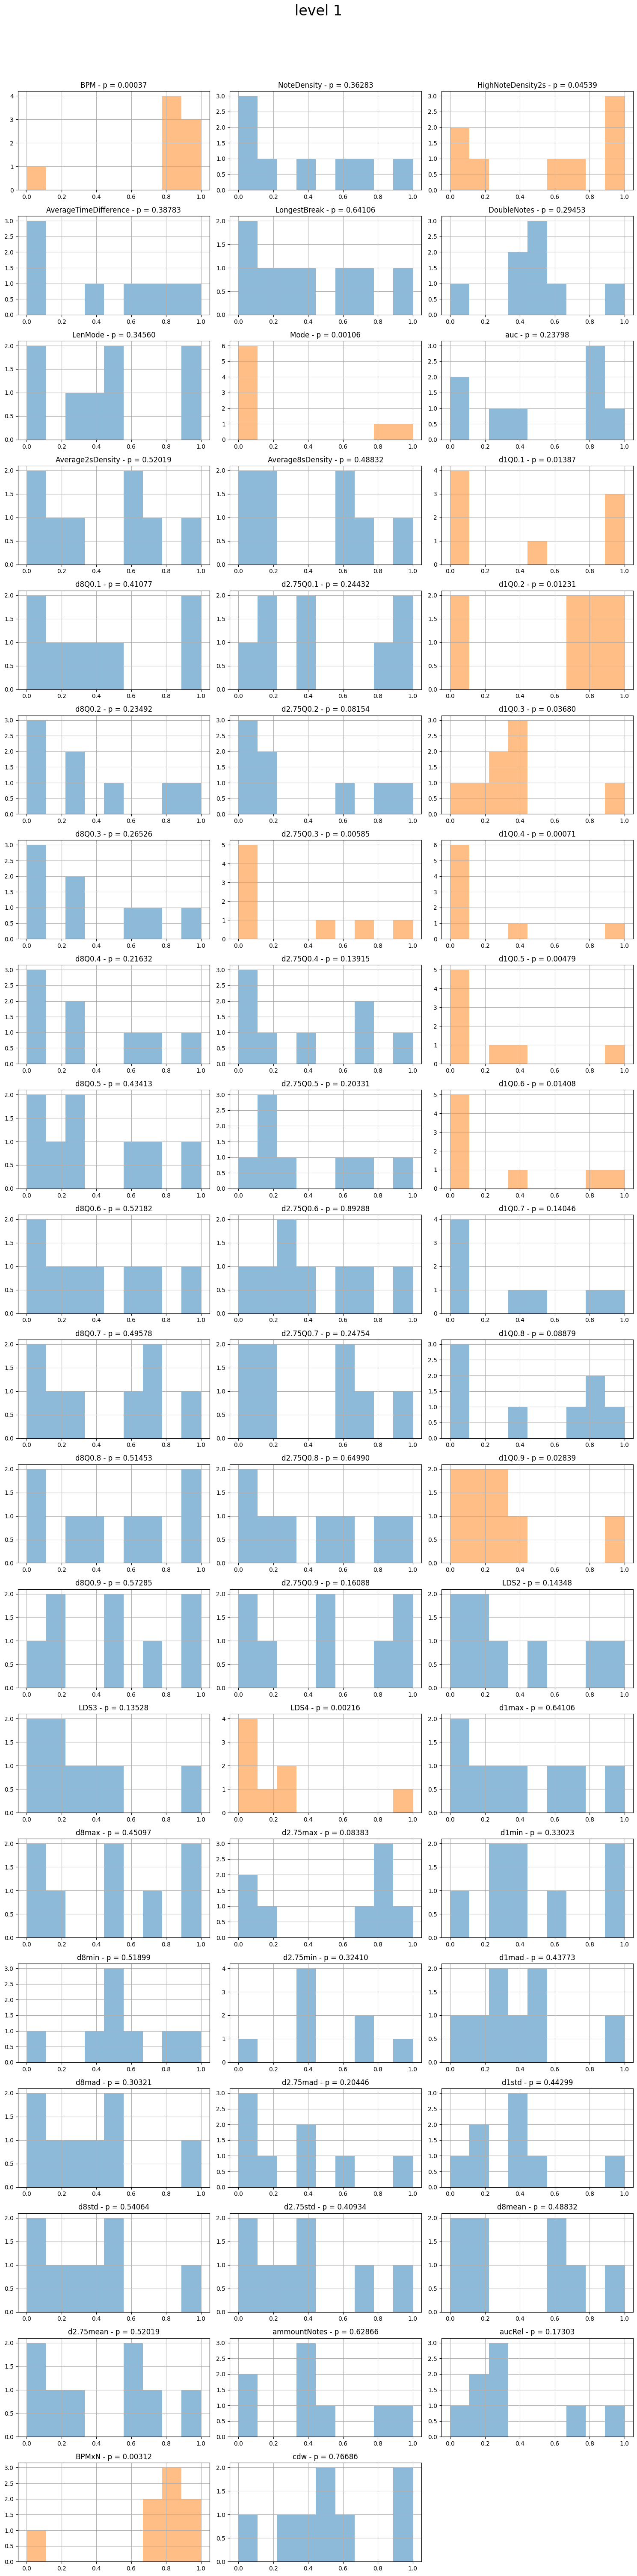

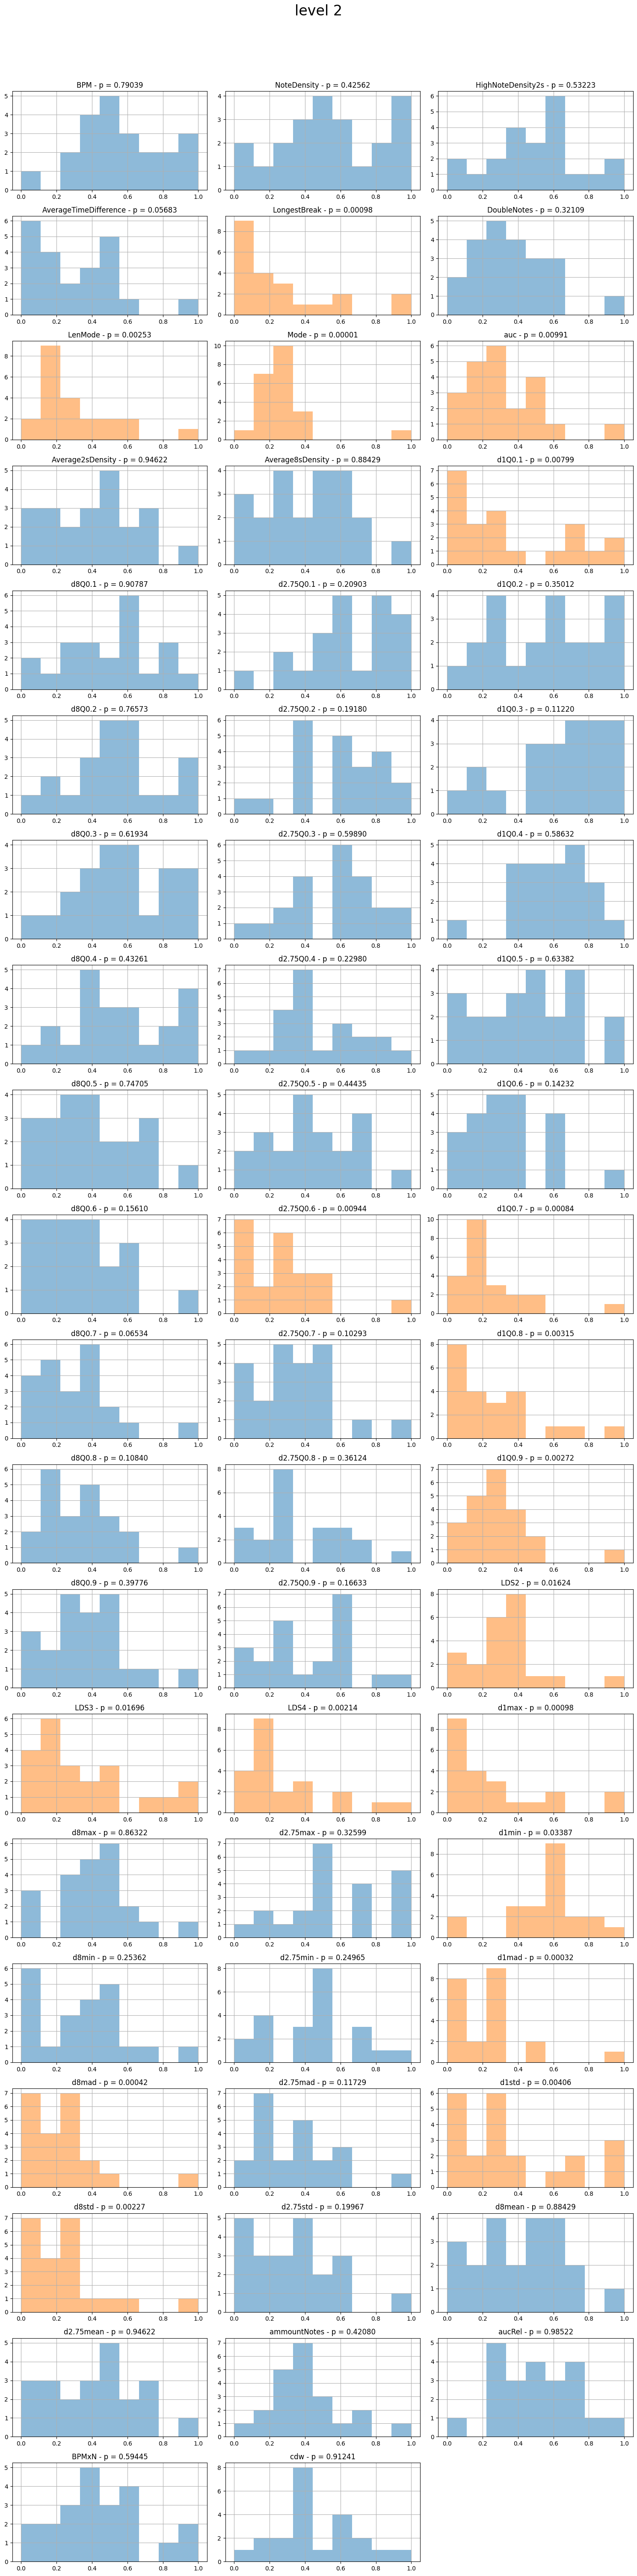

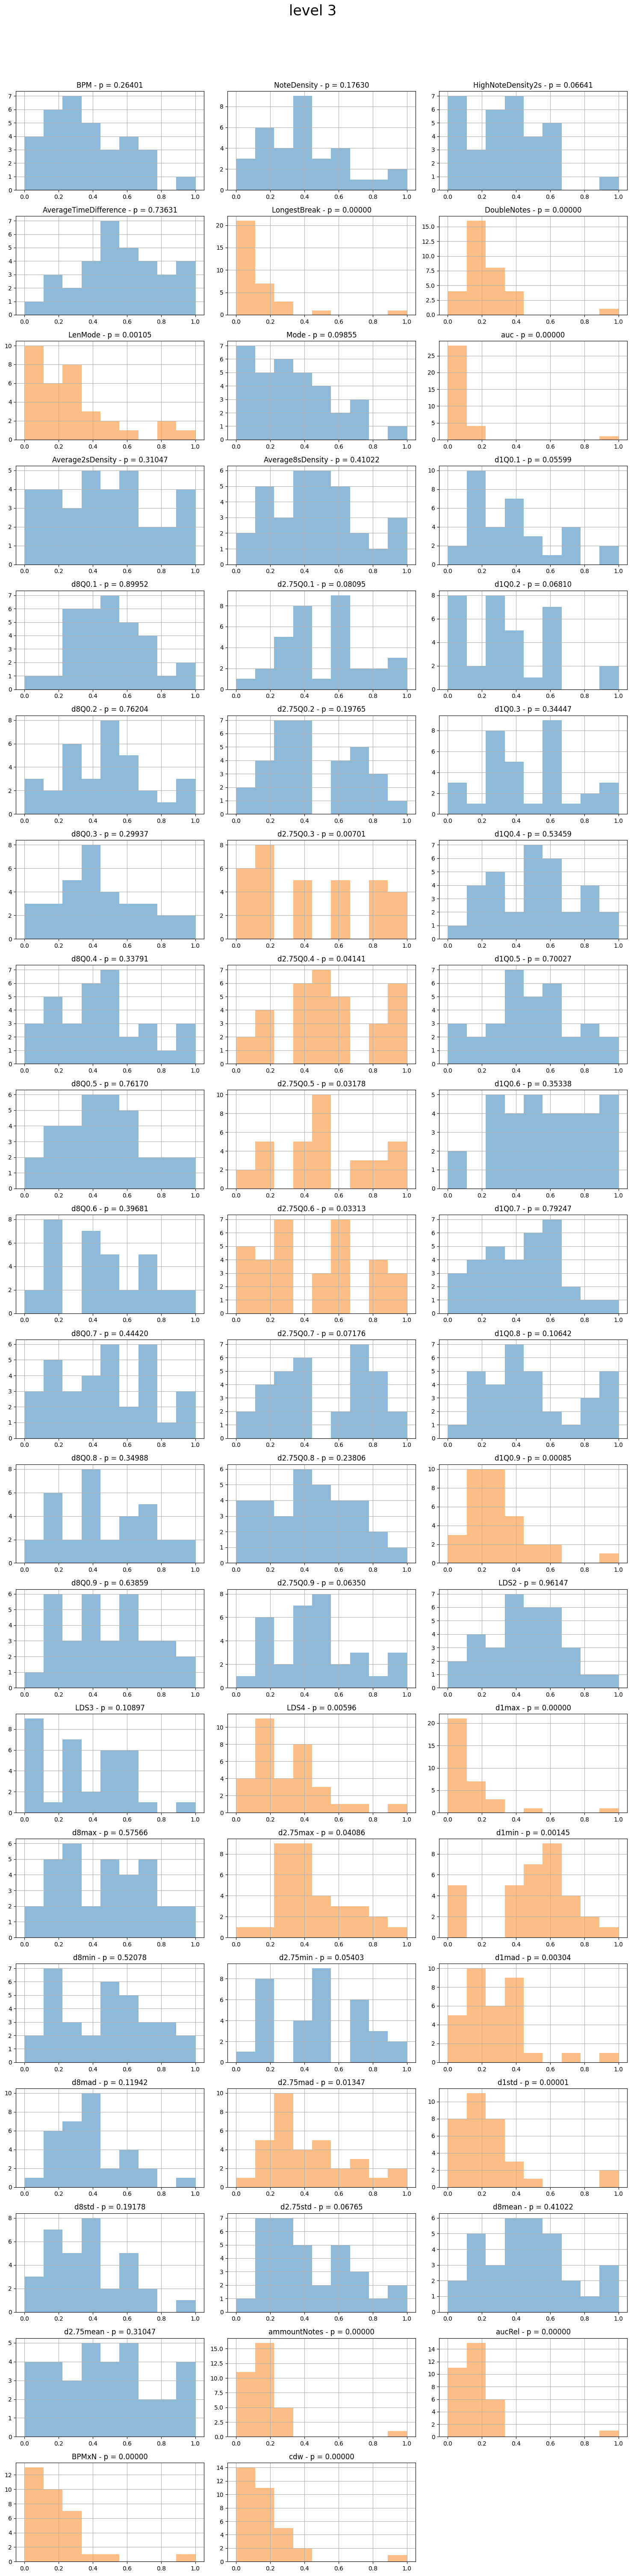

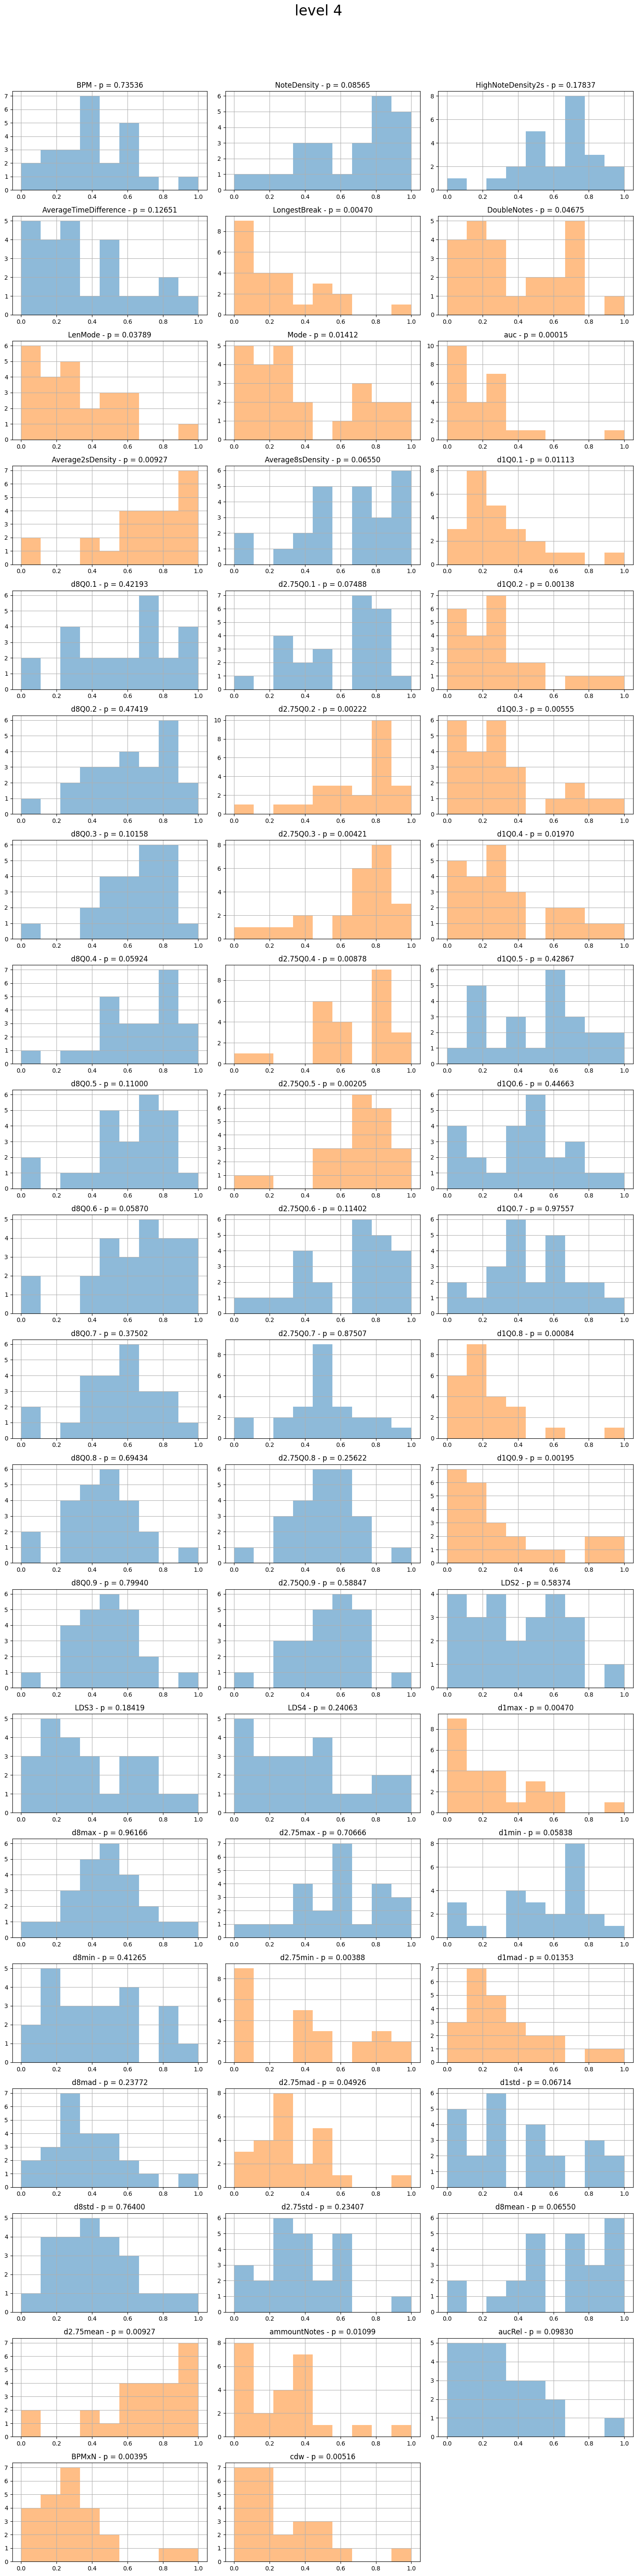

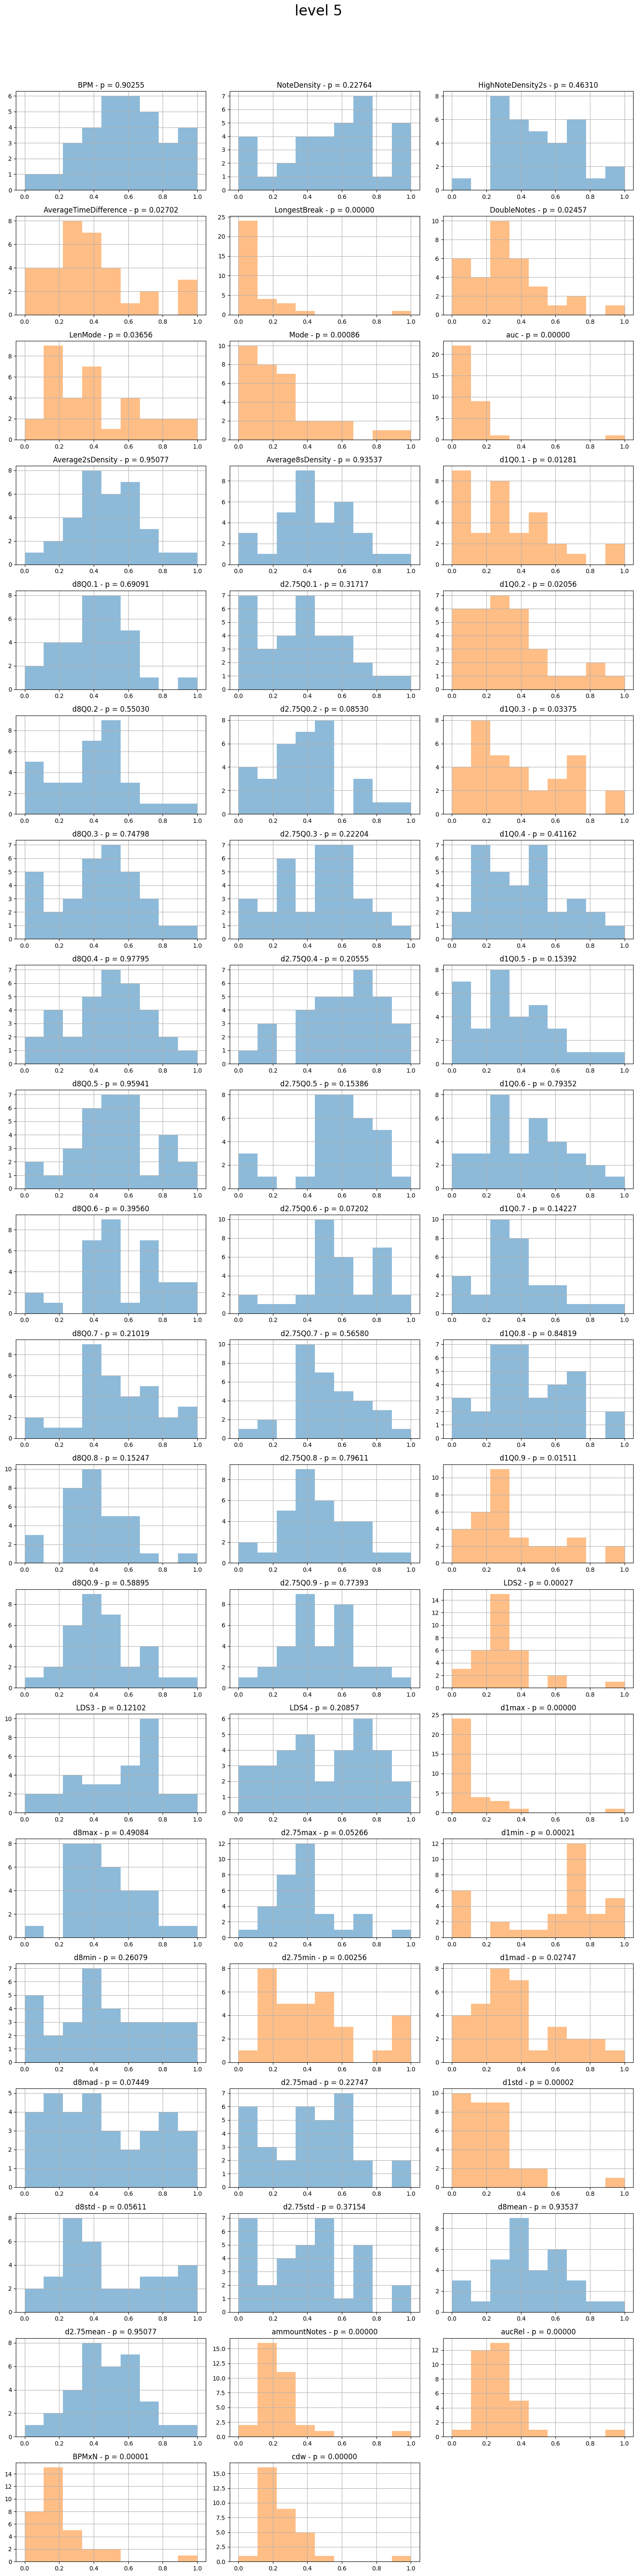

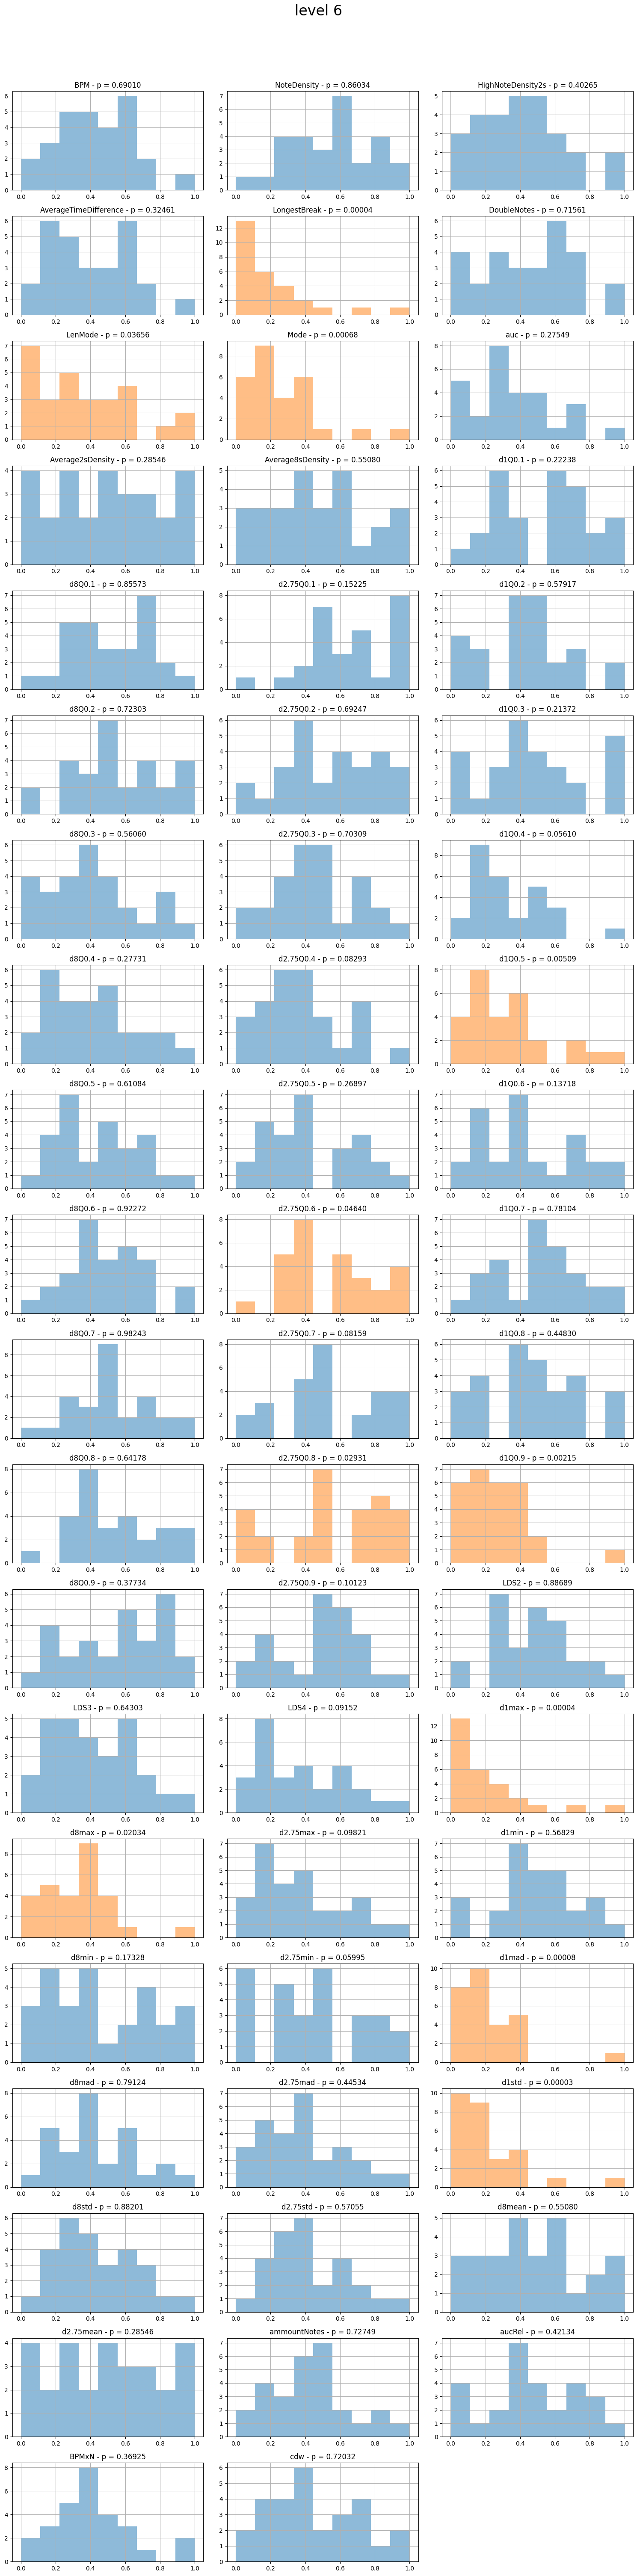

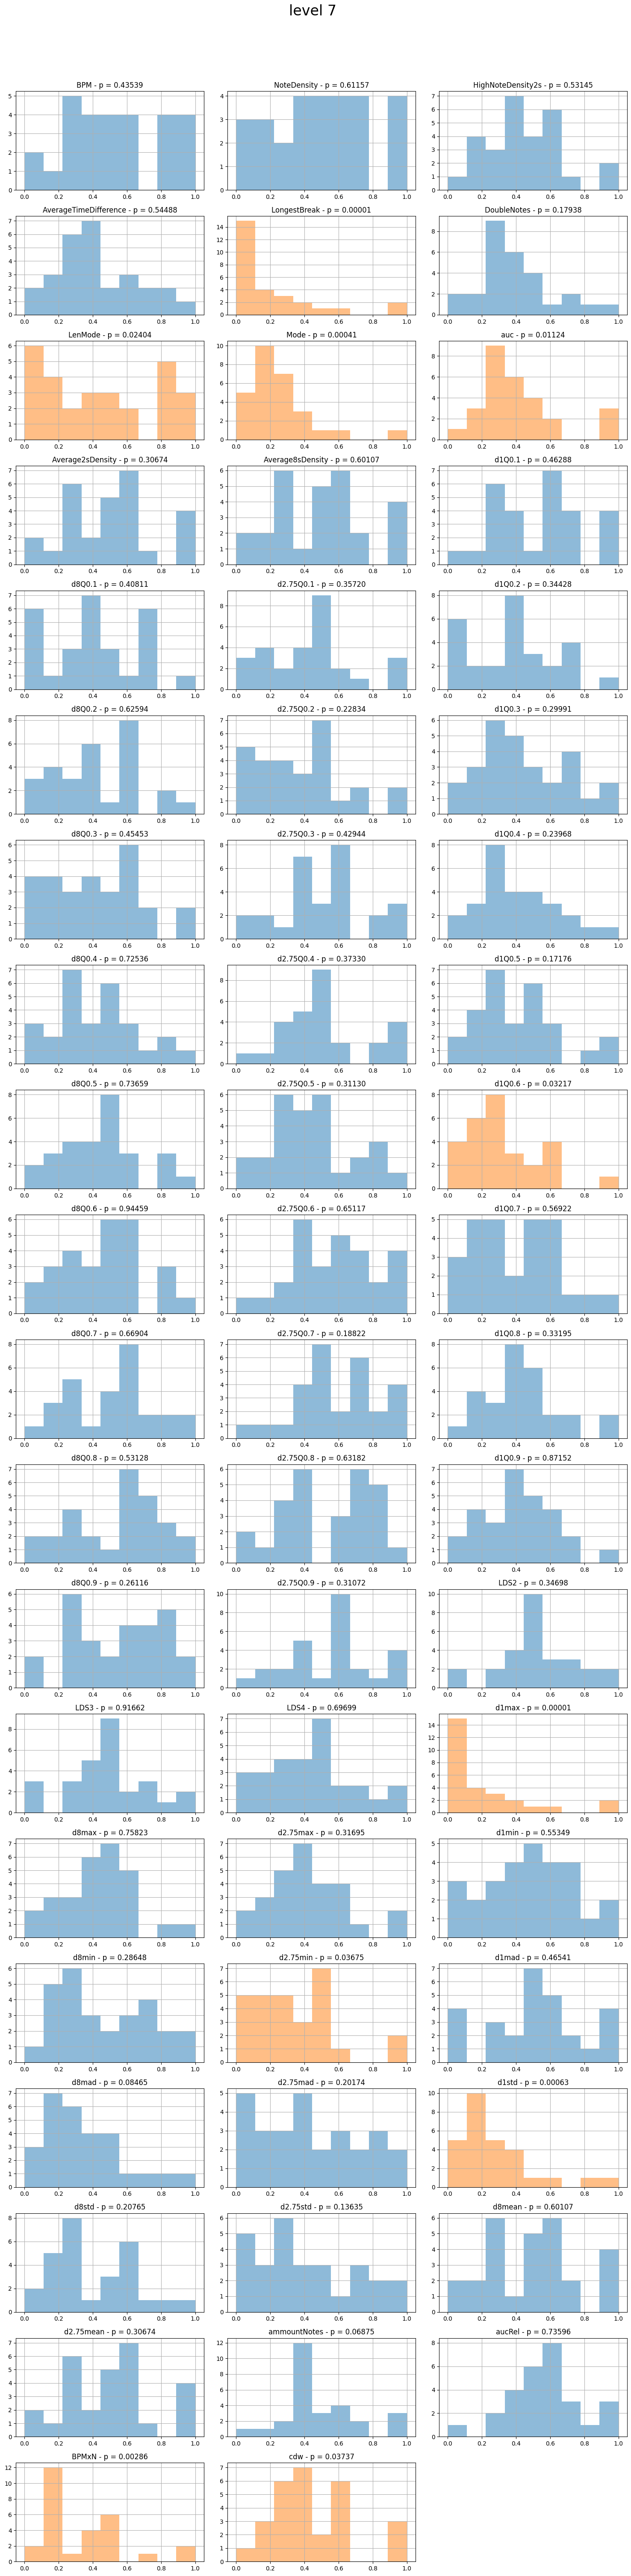

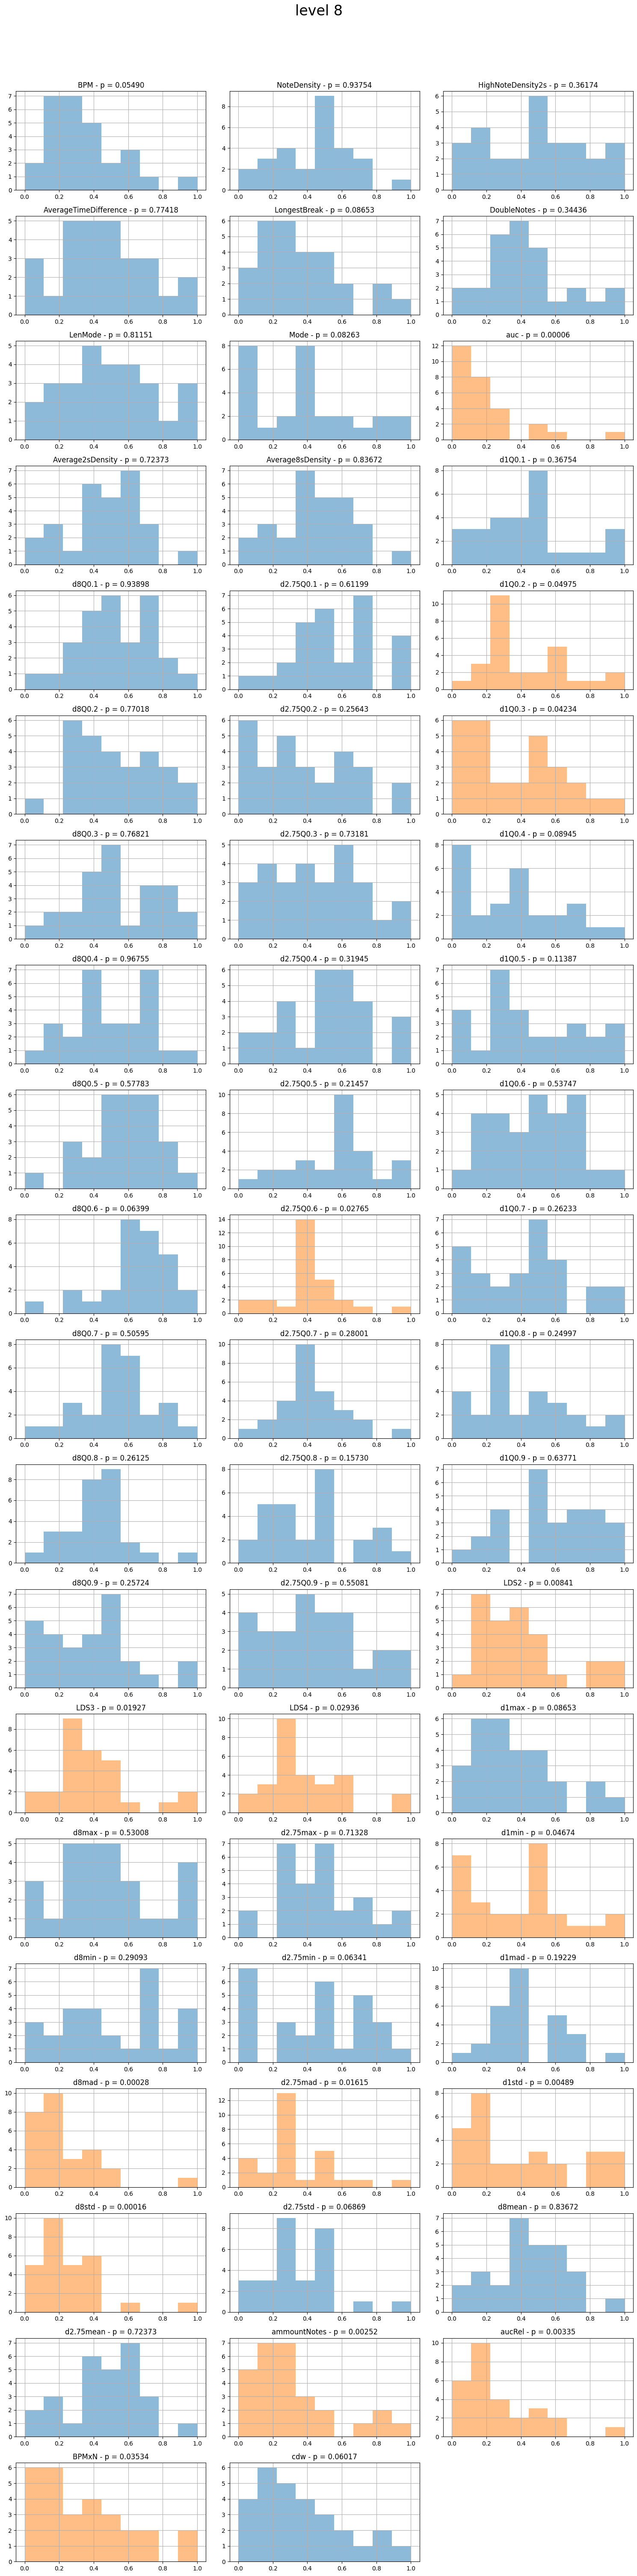

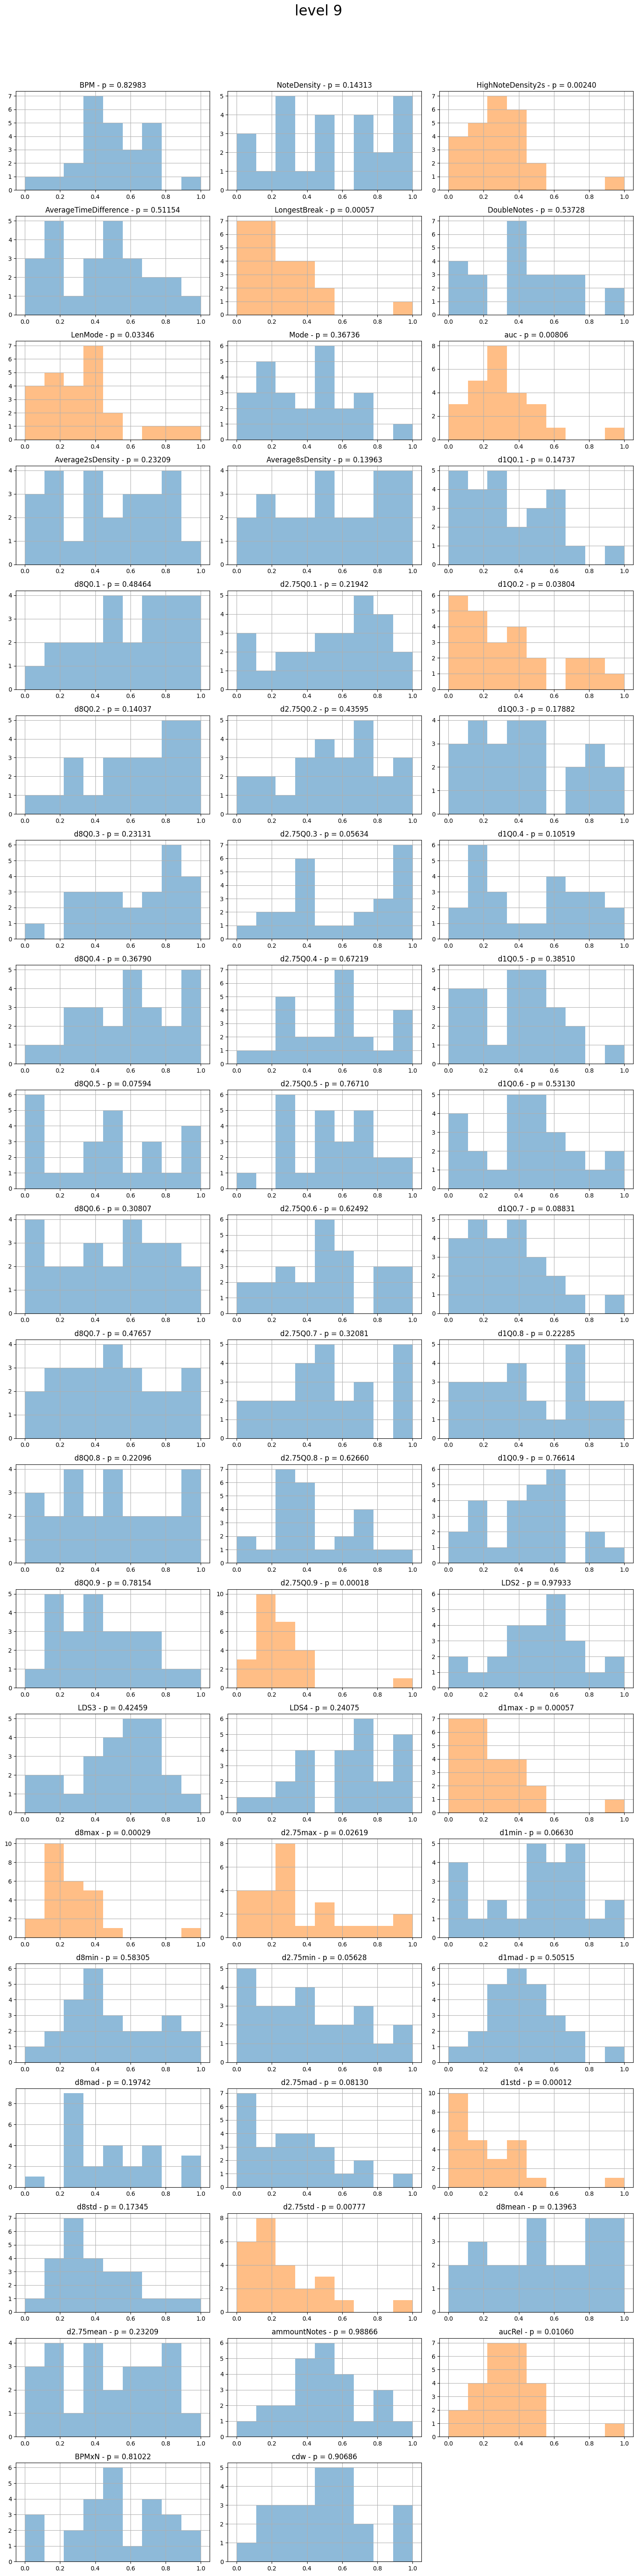

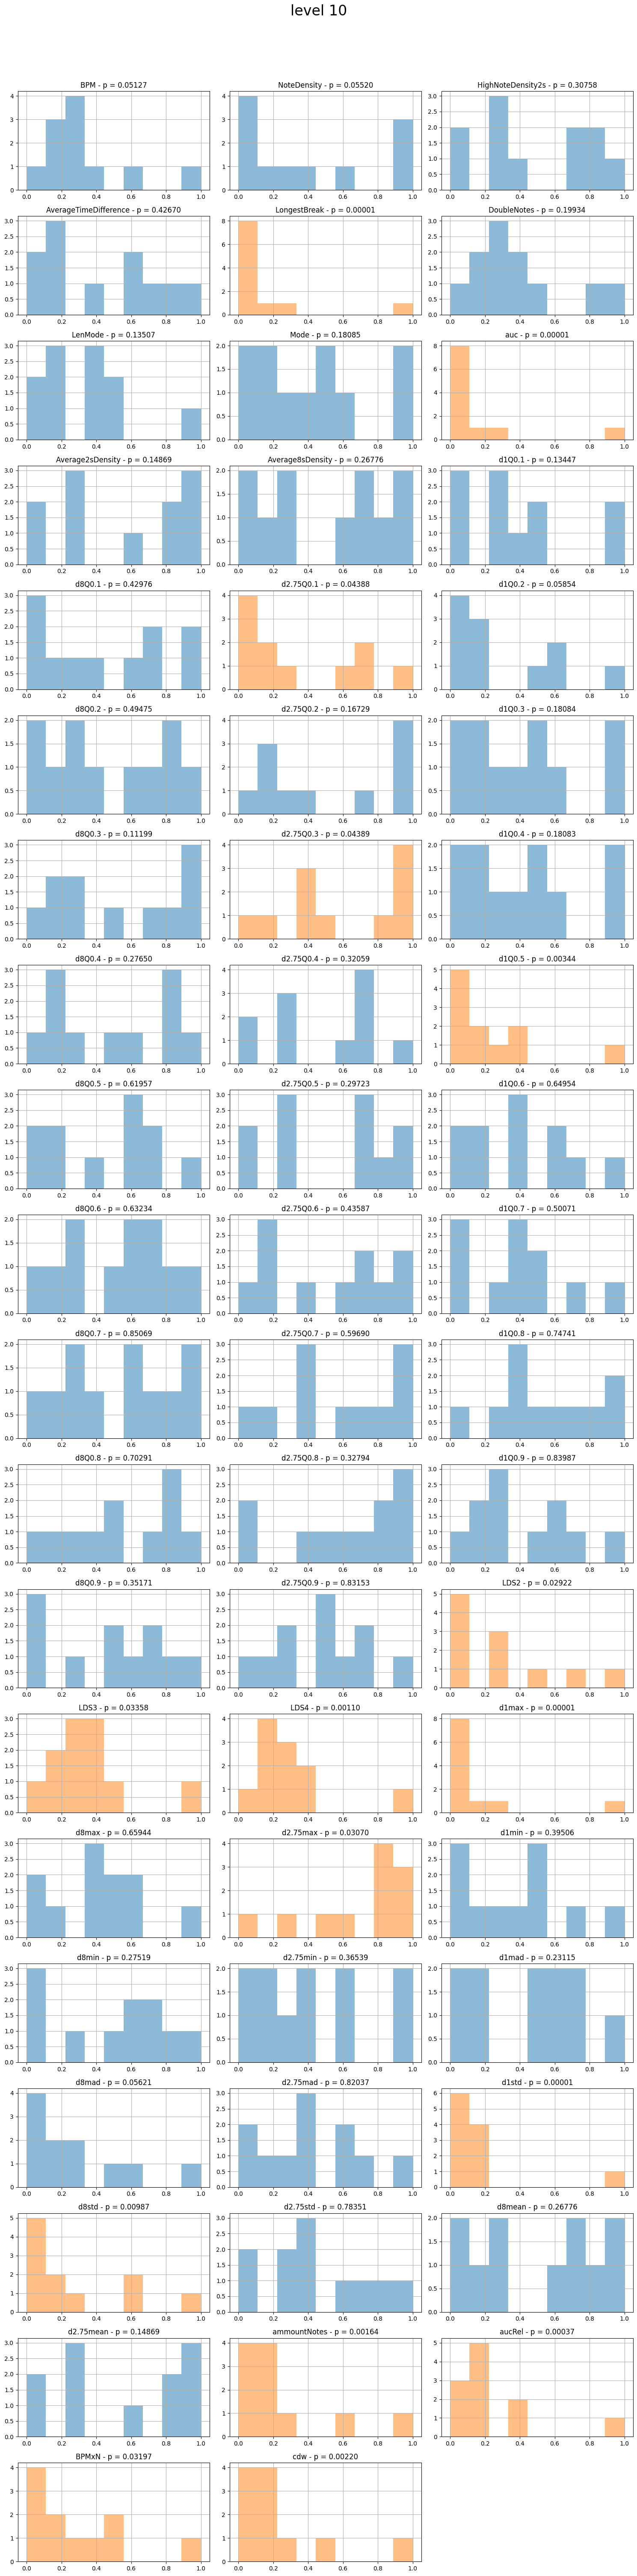

In [ ]:
# distribution
N = len(featureList)

for level in range(1, 11):
    plt.figure(figsize=(15, N))
    df_level = df.loc[df['Difficulty'] == level]
    for i, feature in enumerate(featureList):
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(df_level[[feature]])
        if np.ptp(X_scaled) == 0:
            continue
        _, p_shapiro = stats.shapiro(X_scaled)
        color = cm.tab10.colors[0]
        if p_shapiro < 0.05:
            color = cm.tab10.colors[1]
        plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i + 1)
        plt.hist(X_scaled, bins=9, alpha=0.5, color=color)
        plt.title(f"{featureList[i]} - p = {p_shapiro:.5f}")
        plt.grid(True)

    plt.suptitle(f"level {level}", y=1.02, fontsize=24)
    plt.tight_layout()
    plt.show()


In [ ]:
def convert_to_dict(input_list):
    result_dict = {}
    for value, type_name in input_list:
        if type_name in result_dict:
            result_dict[type_name] += (value,)
        else:
            result_dict[type_name] = (value,)
    return result_dict

def generate_test_list(df):
    for level in range(1, 11):
        df_level = df.loc[df['Difficulty'] == level]
        for feature in featureList:
            feature_values = df_level[feature].dropna()
            if feature_values.empty:
                continue
            if np.ptp(feature_values) == 0:
                continue
            _, p_shapiro = stats.shapiro(feature_values)
            if p_shapiro < 0.05:
                yield (level, feature)

convert_to_dict(list(generate_test_list(df)))

{'BPM': (1,),
 'HighNoteDensity2s': (1, 9),
 'Mode': (1, 2, 4, 5, 6, 7),
 'd1Q0.1': (1, 2, 4, 5),
 'd1Q0.2': (1, 4, 5, 8, 9),
 'd1Q0.3': (1, 4, 5, 8),
 'd2.75Q0.3': (1, 3, 4, 10),
 'd1Q0.4': (1, 4),
 'd1Q0.5': (1, 6, 10),
 'd1Q0.6': (1, 7),
 'd1Q0.9': (1, 2, 3, 4, 5, 6),
 'LDS4': (1, 2, 3, 8, 10),
 'BPMxN': (1, 3, 4, 5, 7, 8, 10),
 'LongestBreak': (2, 3, 4, 5, 6, 7, 9, 10),
 'LenMode': (2, 3, 4, 5, 6, 7, 9),
 'auc': (2, 3, 4, 5, 7, 8, 9, 10),
 'd2.75Q0.6': (2, 3, 6, 8),
 'd1Q0.7': (2,),
 'd1Q0.8': (2, 4),
 'LDS2': (2, 5, 8, 10),
 'LDS3': (2, 8, 10),
 'd1max': (2, 3, 4, 5, 6, 7, 9, 10),
 'd1min': (2, 3, 5, 8),
 'd1mad': (2, 3, 4, 5, 6),
 'd8mad': (2, 8),
 'd1std': (2, 3, 5, 6, 7, 8, 9, 10),
 'd8std': (2, 8, 10),
 'DoubleNotes': (3, 4, 5),
 'd2.75Q0.4': (3, 4),
 'd2.75Q0.5': (3, 4),
 'd2.75max': (3, 9, 10),
 'd2.75mad': (3, 4, 8),
 'ammountNotes': (3, 4, 5, 8, 10),
 'aucRel': (3, 5, 8, 9, 10),
 'cdw': (3, 4, 5, 7, 10),
 'Average2sDensity': (4,),
 'd2.75Q0.2': (4,),
 'd2.75min': (4, 5, 7)

## feature exploration

### count dense window

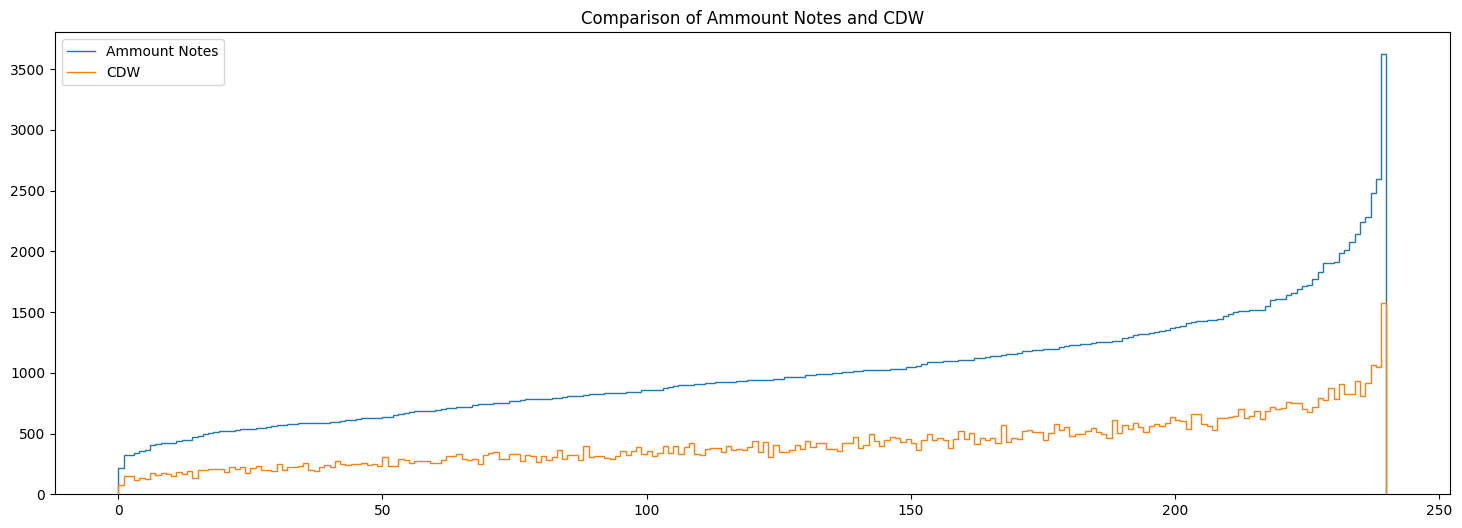

In [ ]:
filtered_df = df.sort_values(['ammountNotes'])
data1 = pd.Series(filtered_df['ammountNotes'].values)
data2 = pd.Series(filtered_df['cdw'].values)

plt.figure(figsize=(18, 6))
plt.stairs(data1, label='Ammount Notes')
plt.stairs(data2, label='CDW')
plt.title('Comparison of Ammount Notes and CDW')
plt.legend()
plt.show()

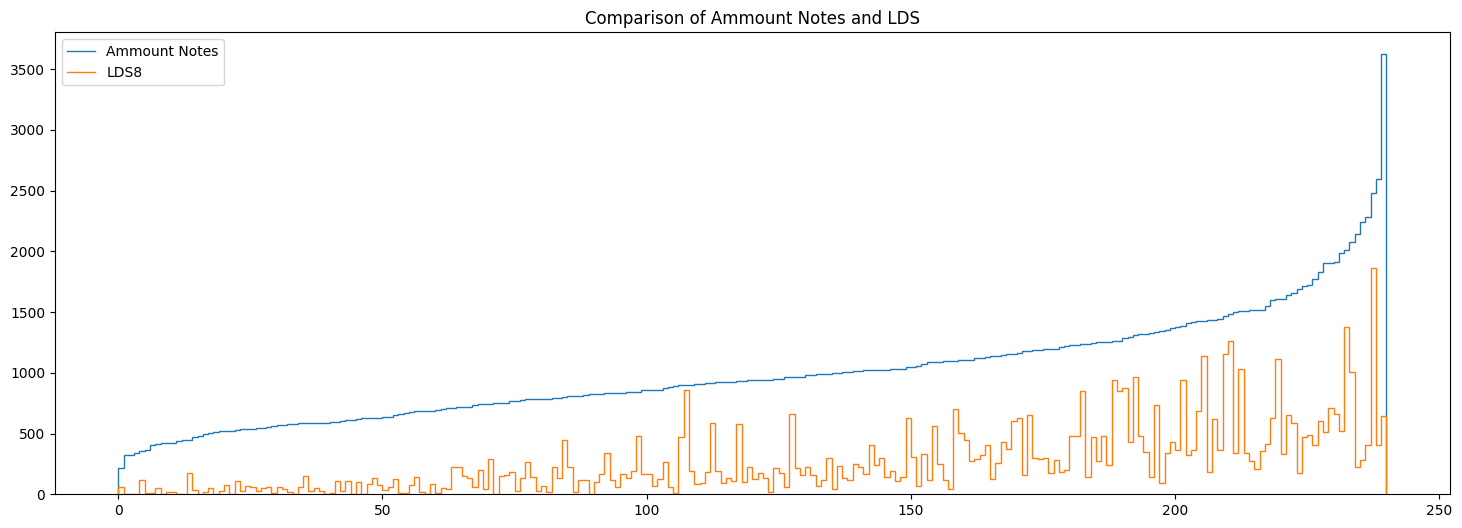

In [ ]:
filtered_df = df.sort_values(['ammountNotes'])
data1 = pd.Series(filtered_df['ammountNotes'].values)
# data2 = pd.Series(filtered_df['LDS2'].values)
# data3 = pd.Series(filtered_df['LDS4'].values)
# data4 = pd.Series(filtered_df['LDS6'].values)
data5 = pd.Series(filtered_df['LDS8'].values)


plt.figure(figsize=(18, 6))
plt.stairs(data1, label='Ammount Notes')
# plt.stairs(data2, label='LDS2')
# plt.stairs(data3, label='LDS4')
# plt.stairs(data4, label='LDS6')
plt.stairs(data5, label='LDS8')

plt.title('Comparison of Ammount Notes and LDS')
plt.legend()
plt.show()

In [ ]:
filtered_df = df.sort_values(['LDS8'])
data1 = pd.Series(filtered_df['LDS8'].values)
data2 = pd.Series(filtered_df['level'].values)

plt.figure(figsize=(18, 6))
plt.stairs(data1, label='Ammount Notes')
plt.stairs(data2, label='CDW')
plt.title('Comparison of Ammount Notes and CDW')
plt.legend()
plt.show()

### series cum_agg

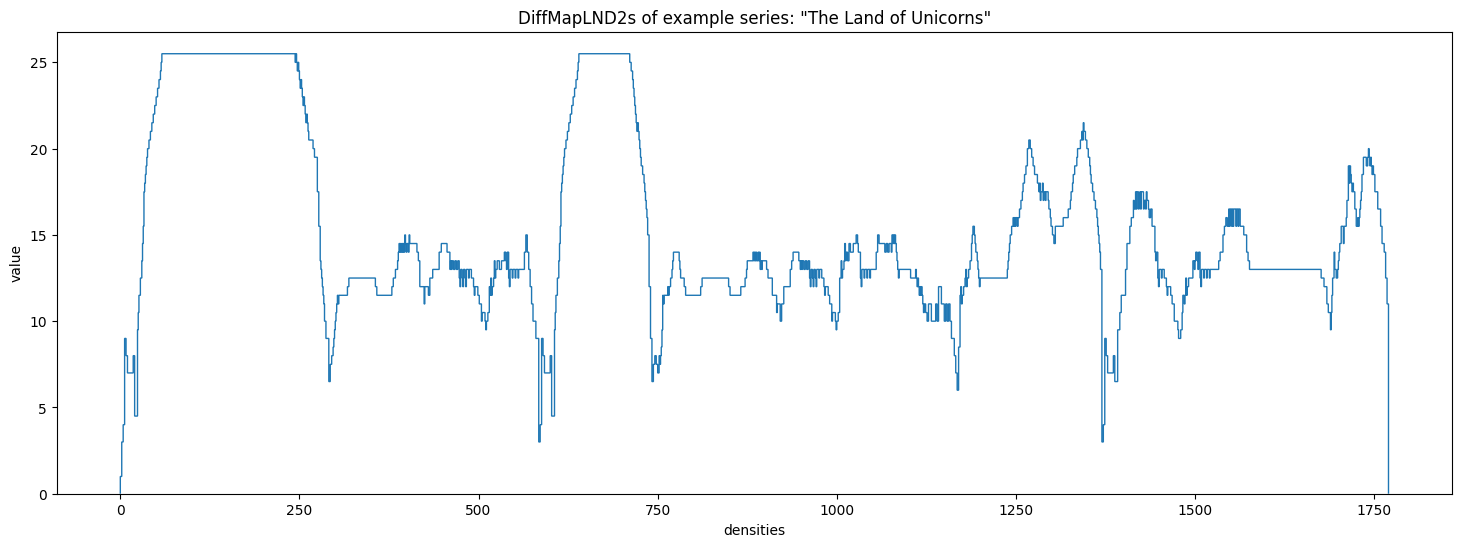

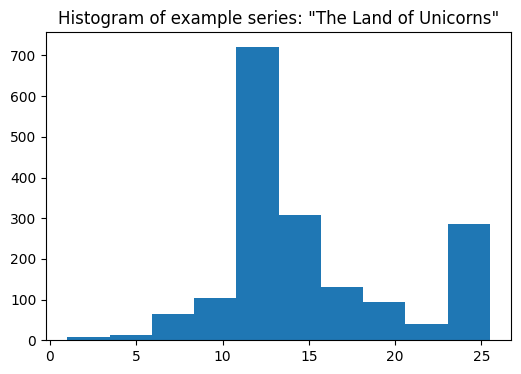

In [ ]:
filtered_df = df.loc[df['Difficulty'] == 10]
data = pd.Series(filtered_df['DiffMapLND2s'].values[1])

plt.figure(figsize=(18, 6))
plt.stairs(data)
plt.title(f"DiffMapLND2s of example series: \"{filtered_df['SongName'].iloc[1]}\"")
plt.xlabel('densities')
plt.ylabel('value')
plt.show()
plt.figure(figsize=(6, 4))
plt.hist(data, bins=10)
plt.title(f"Histogram of example series: \"{filtered_df['SongName'].iloc[1]}\"")
plt.show()

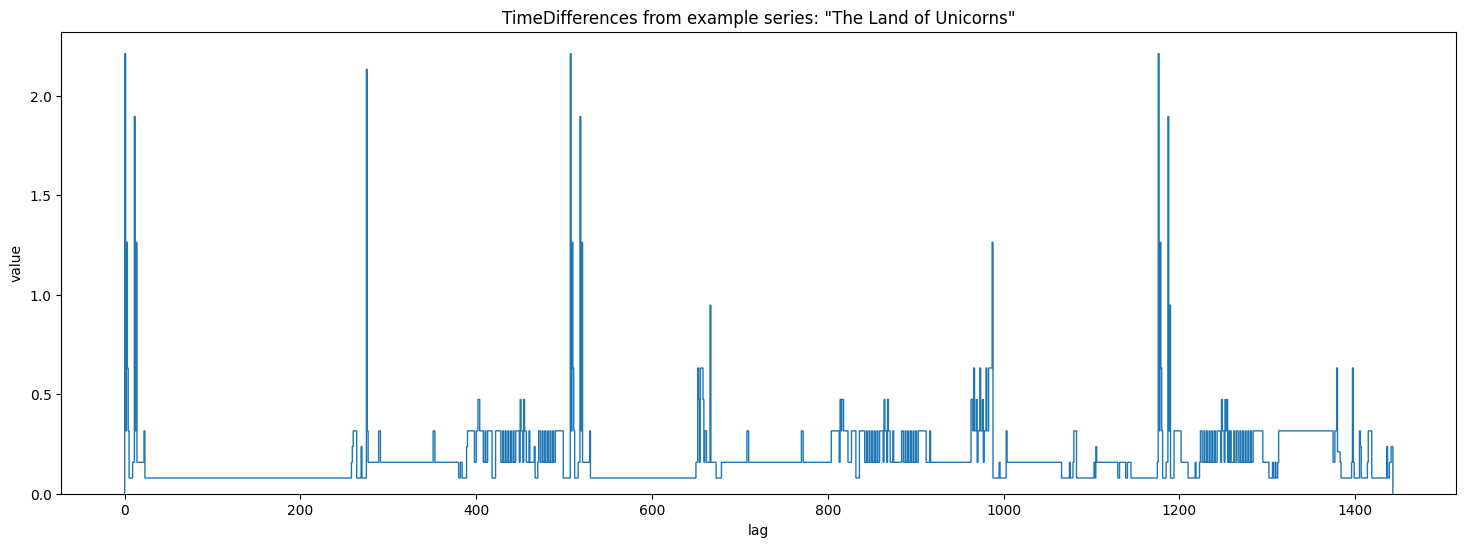

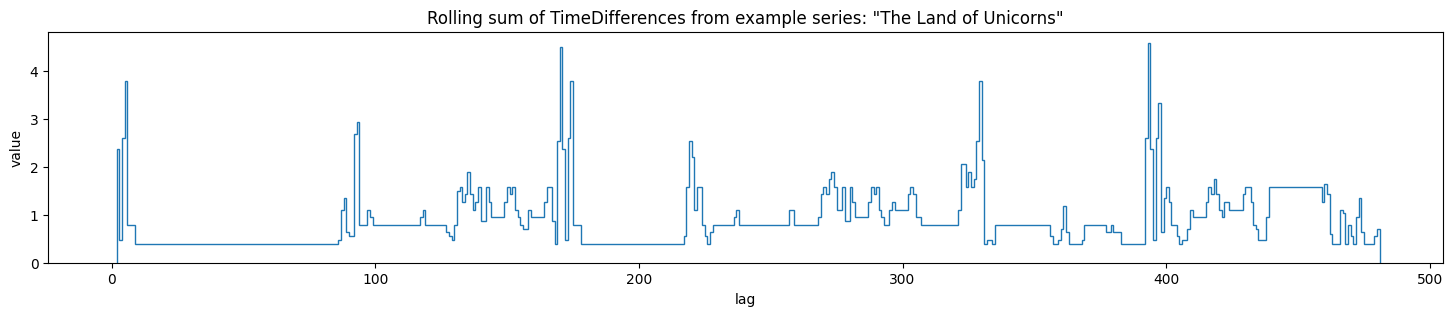

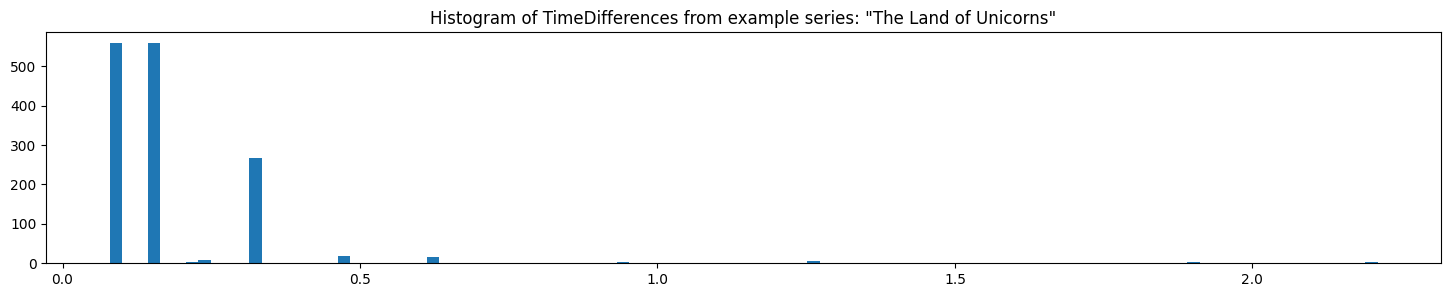

count    1443.000000
mean        0.181201
std         0.184219
min         0.078947
25%         0.078947
50%         0.157895
75%         0.157895
max         2.210526
dtype: float64

In [ ]:
filtered_df = df.loc[df['Difficulty'] == 10]
data = pd.Series(filtered_df['TimeDifferences'].values[1])
data2 = data.rolling(5, step=3).sum()
plt.figure(figsize=(18, 6))
plt.stairs(data)
plt.title(f"TimeDifferences from example series: \"{filtered_df['SongName'].iloc[1]}\"")
plt.xlabel('lag')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(18, 3))
plt.stairs(data2)
plt.title(f"Rolling sum of TimeDifferences from example series: \"{filtered_df['SongName'].iloc[1]}\"")
plt.xlabel('lag')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(18, 3))
plt.hist(data, bins=100)
plt.title(f"Histogram of TimeDifferences from example series: \"{filtered_df['SongName'].iloc[1]}\"")
plt.show()

data.describe()

## univariate

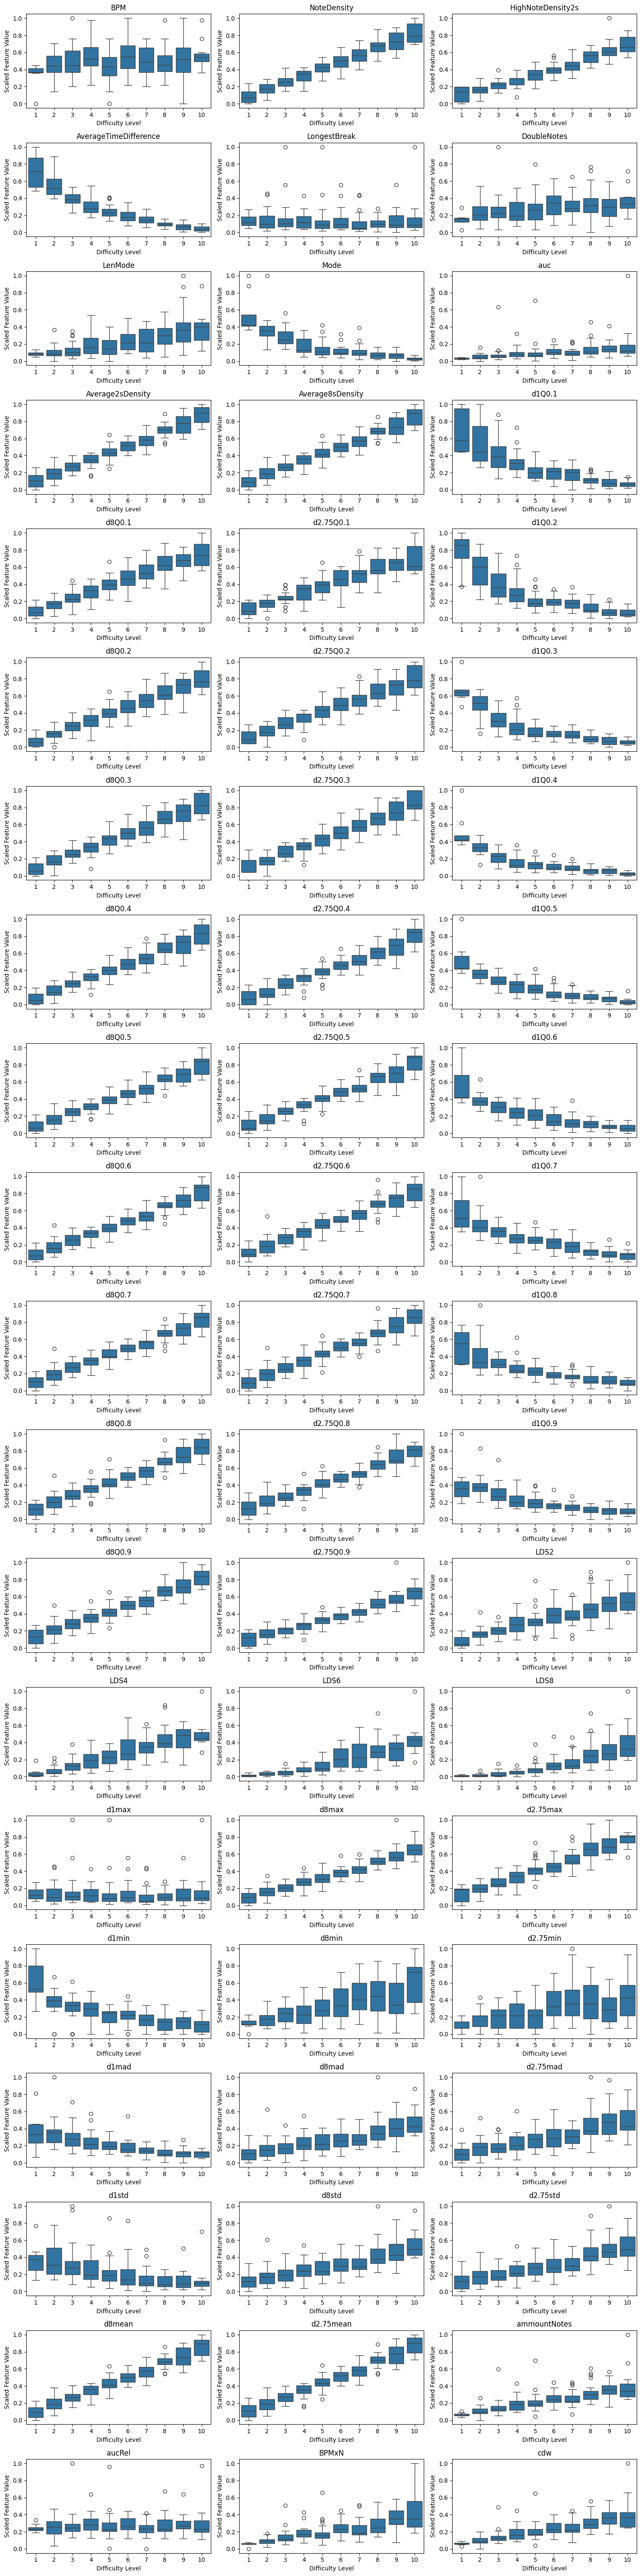

In [ ]:
N = len(featureList)
X = df[featureList]
y = df[targetFeature]

plt.figure(figsize=(15, N))
for i in range(N):
    plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i % N + 1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.iloc[:, i].values.reshape(-1, 1))

    sns.boxplot(x=y.Difficulty, y=X_scaled.squeeze())
    plt.xlabel('Difficulty Level')
    plt.ylabel('Scaled Feature Value')
    plt.title(featureList[i])

plt.tight_layout()
plt.show()


this part is only used to generate plots individually:

In [ ]:
def index_of_first_occurrence(lst, search_string):
    try:
        idx = lst.index(search_string)
        return idx
    except ValueError:
        return -1

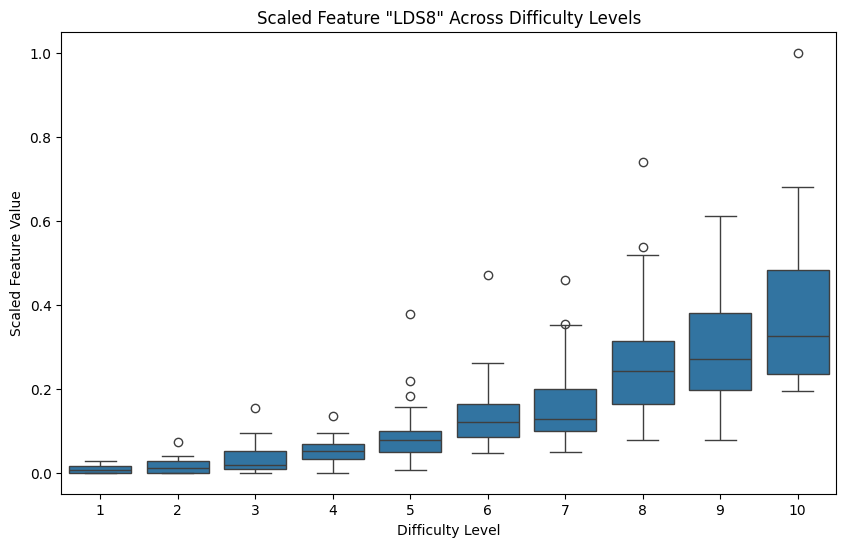

In [ ]:
feature_number = index_of_first_occurrence(featureList, "LDS8")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.iloc[:, feature_number].values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.boxplot(x=y.Difficulty, y=X_scaled.squeeze())
plt.xlabel('Difficulty Level')
plt.ylabel('Scaled Feature Value')
plt.title('Scaled Feature "' + featureList[feature_number] + '" Across Difficulty Levels')
plt.show()


## 3d model
this is a simple plot to visualize the relationship between 3 features

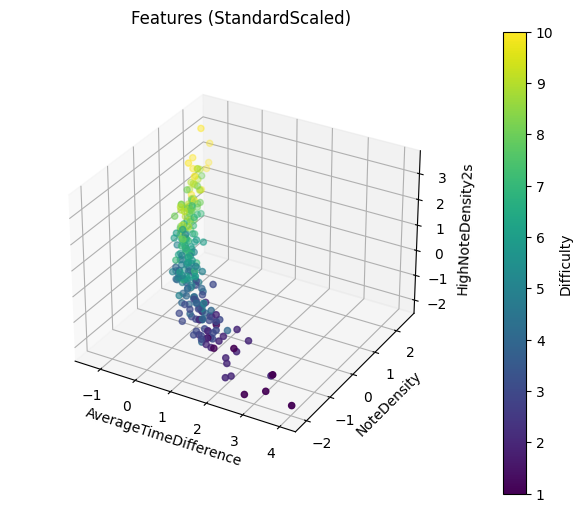

In [ ]:
X_dimensions = ["AverageTimeDifference", "NoteDensity", "HighNoteDensity2s"]
targetFeature = ["Difficulty"]
X = df[X_dimensions]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y.values, cmap='viridis')

ax.set_xlabel(X_dimensions[0])
ax.set_ylabel(X_dimensions[1])
ax.set_zlabel(X_dimensions[2])
ax.set_title('Features (StandardScaled)')

ax.set_box_aspect(None, zoom=0.85)

cbar = fig.colorbar(scatter, ax=ax, label='Difficulty')

plt.show()


## 2d

The interpretation is simple: we have a better classification if each group is close to each other in a narrow range and well delimited from other groups

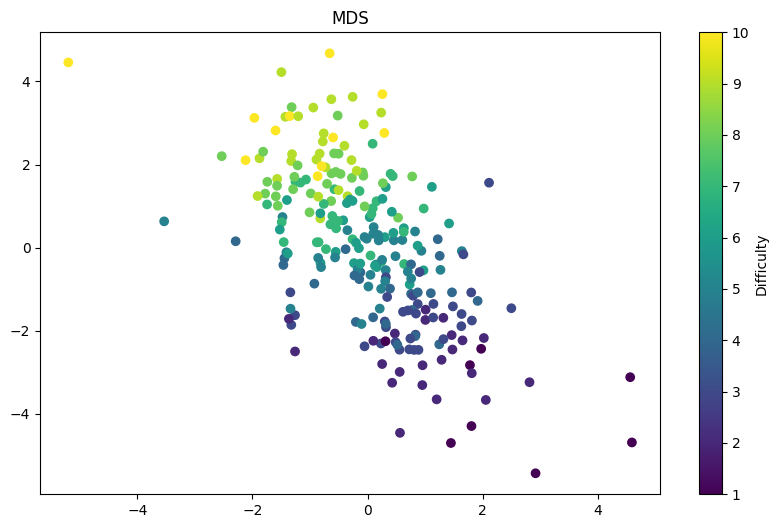

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = MDS(n_components=2, normalized_stress='auto')
transformed_data = model.fit_transform(X_scaled)

df['MDS_1'] = transformed_data[:, 0]
df['MDS_2'] = transformed_data[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['MDS_1'], df['MDS_2'], c=y.Difficulty, cmap='viridis')
plt.title('MDS')
plt.colorbar(label='Difficulty')
plt.show()


MDS: Optimized visualization of similarities or differences between data points in a low-dimensional space

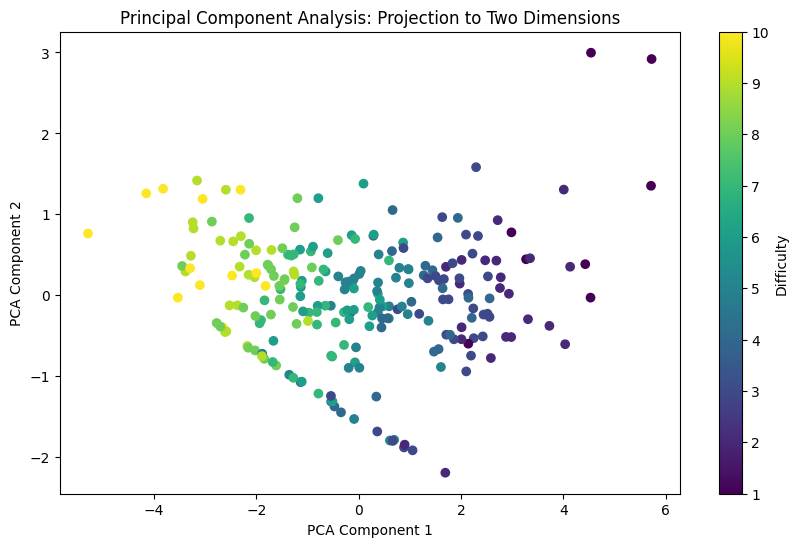

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA_Component_1'] = X_pca[:, 0]
df['PCA_Component_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.Difficulty, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Principal Component Analysis: Projection to Two Dimensions')
plt.colorbar(label='Difficulty')
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM
X_pca = df[['PCA_Component_1', 'PCA_Component_2']].values
detector = OneClassSVM(nu=0.01)
outlier_labels = detector.fit_predict(X_pca)
df['Outlier'] = outlier_labels
print(df[df['Outlier'] == -1][['SongName', 'Difficulty']])

                                SongName  Difficulty
33                                  Loki           2
119                   Born For One Thing           8
123                        Join The Riot           1
209  The Fires of Ancient Cosmic Destiny          10
216                       Randy Dandy Oh           1


In [ ]:
df.loc[df['PCA_Component_2'].idxmax()][['SongName', 'Difficulty']]

SongName      Join The Riot
Difficulty                1
Name: 123, dtype: object

In LDA, the class information of the data is used to find an optimal linear discriminant that enables maximum separation between the classes. (better groups -> correlation in classdepenecy)

PCA: the class information is not relevant

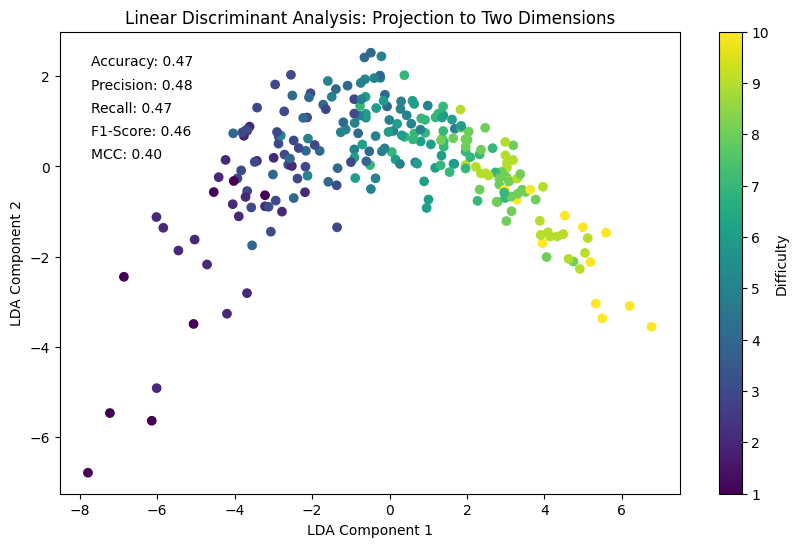

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_encoded)

df['LDA_Component_1'] = X_lda[:, 0]
df['LDA_Component_2'] = X_lda[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y.Difficulty, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('Linear Discriminant Analysis: Projection to Two Dimensions')
plt.colorbar(label='Difficulty')

y_pred = lda.predict(X_scaled)
accuracy = lda.score(X_scaled, y_encoded)
precision = metrics.precision_score(y_encoded, y_pred, average='weighted')
recall = metrics.recall_score(y_encoded, y_pred, average='weighted')
f1 = metrics.f1_score(y_encoded, y_pred, average='weighted')
MCC = metrics.matthews_corrcoef(y_encoded, y_pred)

settings = {'transform': plt.gca().transAxes, 'fontsize': 10, 'verticalalignment': 'top'}
plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', **settings)
plt.text(0.05, 0.90, f'Precision: {precision:.2f}', **settings)
plt.text(0.05, 0.85, f'Recall: {recall:.2f}', **settings)
plt.text(0.05, 0.80, f'F1-Score: {f1:.2f}', **settings)
plt.text(0.05, 0.75, f'MCC: {MCC:.2f}', **settings)
plt.show()

In [ ]:
df.loc[df['LDA_Component_1'].idxmax()][['SongName', 'Difficulty']]

SongName      The Land of Unicorns
Difficulty                       9
Name: 41, dtype: object

In [ ]:
df.loc[df['Difficulty'] == 8].sort_values(by='LDA_Component_1')[['SongName', 'Difficulty', 'LDA_Component_1']]

SongName  Difficulty  LDA_Component_1
116      The Next One Down           8         1.328180
5             Valhalleluja           8         1.360557
122              To Erebor           8         1.644179
158          Dead and Gone           8         1.854879
167               Mediator           8         1.959025
74        To Hell and Back           8         1.968998
80                  Heroes           8         2.016973
119     Born For One Thing           8         2.044467
160            Chomp Chomp           8         2.325986
43          Au Petit Matin           8         2.362857
110                 Utopia           8         2.470258
85                 Skyfall           8         2.765519
83              Rise Again           8         2.833137
197               Santiana           8         2.833785
92                  Tribal           8         2.889655
101            Sanaton Maa           8         3.010207
182              Hypa Hypa           8         3.016680
212          Night Witches           8         3.083233
188            Battlefield           8         3.140686
176              Kammthaar           8         3.150782
149           Memento Mori           8         3.195007
143                 Mexico           8         3.307818
239              Ambiramus           8         3.375508
65   Great Marquis Of Hell           8         3.419716
137        We Are The Fire           8         3.509190
146             Powersnake           8         3.773241
191       Heart Demolition           8         4.055563
32             Gloryhammer           8         4.748297

In [ ]:
feature_weighting = pd.DataFrame(lda.coef_, columns=X.columns, index=sorted(y.Difficulty.unique()))
feature_weighting['MaxInfluence'] = feature_weighting[X.columns].apply(max_abs_column_name, axis=1)
feature_weighting['sMaxInfluence'] = feature_weighting[X.columns].apply(second_max_abs_column_name, axis=1)
feature_weighting['MinInfluence'] = feature_weighting[X.columns].apply(min_abs_column_name, axis=1)

feature_weighting

NoteDensity  AverageTimeDifference  HighNoteDensity2s     d1min       cdw  \
1      0.497214              12.460283          -4.064727  2.721784  0.959488   
2     -1.617379               6.337512          -4.015279  0.363121  0.074250   
3     -3.614091               0.764445          -3.278513  0.159374 -0.123783   
4     -3.935492              -1.641047          -2.229483  0.158730 -0.040968   
5     -2.422735              -2.463206          -1.149607 -0.373664 -0.412193   
6     -0.815251              -2.422569           0.139592  0.118413 -0.052254   
7      1.246403              -2.010008           1.076070 -0.445671 -0.544711   
8      3.506038              -1.177847           3.289673 -0.436011 -0.013832   
9      4.701221              -0.559697           4.517407 -0.165837  0.613390   
10     8.516755               2.238443           7.160194 -0.095772  0.978499   

             MaxInfluence      sMaxInfluence MinInfluence  
1   AverageTimeDifference  HighNoteDensity2s  NoteDensity  
2   AverageTimeDifference  HighNoteDensity2s          cdw  
3             NoteDensity  HighNoteDensity2s          cdw  
4             NoteDensity  HighNoteDensity2s          cdw  
5   AverageTimeDifference        NoteDensity        d1min  
6   AverageTimeDifference        NoteDensity          cdw  
7   AverageTimeDifference        NoteDensity        d1min  
8             NoteDensity  HighNoteDensity2s          cdw  
9             NoteDensity  HighNoteDensity2s        d1min  
10            NoteDensity  HighNoteDensity2s        d1min

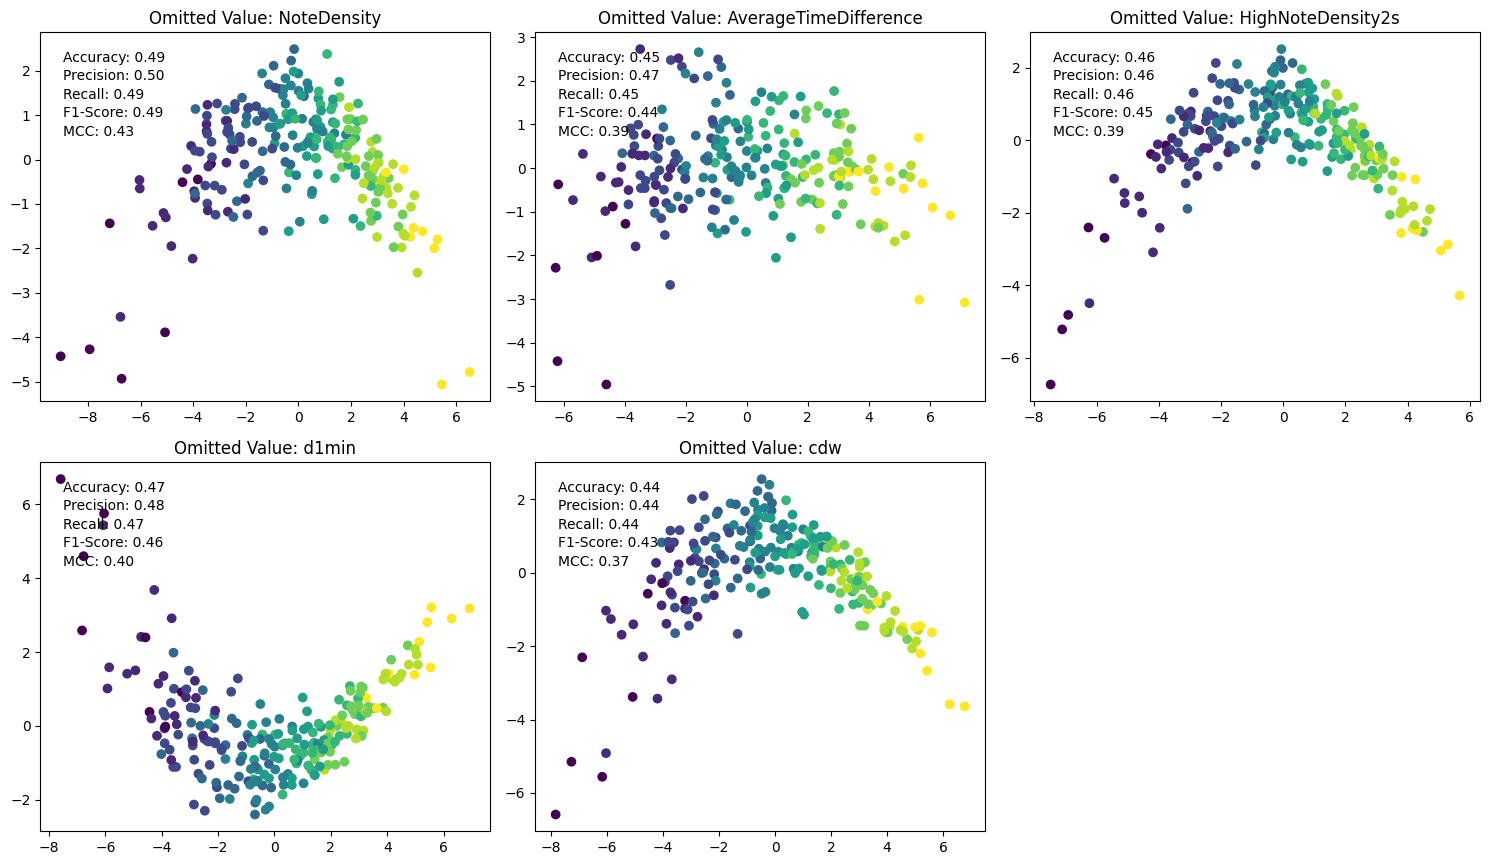

In [ ]:
featureList = x_test_dims
y = df[targetFeature]
N = len(featureList)
plt.figure(figsize=(15, N * 1.75))

for i, (features, omitted_value) in enumerate(generate_leave_one_value_out_sequence(featureList)):
    plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i % N + 1)
    X = df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y.values.ravel())

    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, y_encoded)

    df['LDA_Component_1'] = X_lda[:, 0]
    df['LDA_Component_2'] = X_lda[:, 1]

    plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y.Difficulty, cmap='viridis')

    plt.title(f'Omitted Value: {omitted_value}')

    y_pred = lda.predict(X_scaled)

    accuracy = lda.score(X_scaled, y_encoded)
    precision = metrics.precision_score(y_encoded, y_pred, average='weighted')
    recall = metrics.recall_score(y_encoded, y_pred, average='weighted')
    f1 = metrics.f1_score(y_encoded, y_pred, average='weighted')
    MCC = metrics.matthews_corrcoef(y_encoded, y_pred)

    settings = {'transform': plt.gca().transAxes, 'fontsize': 10, 'verticalalignment': 'top'}
    plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', **settings)
    plt.text(0.05, 0.90, f'Precision: {precision:.2f}', **settings)
    plt.text(0.05, 0.85, f'Recall: {recall:.2f}', **settings)
    plt.text(0.05, 0.80, f'F1-Score: {f1:.2f}', **settings)
    plt.text(0.05, 0.75, f'MCC: {MCC:.2f}', **settings)

plt.tight_layout()
plt.show()

## 1d

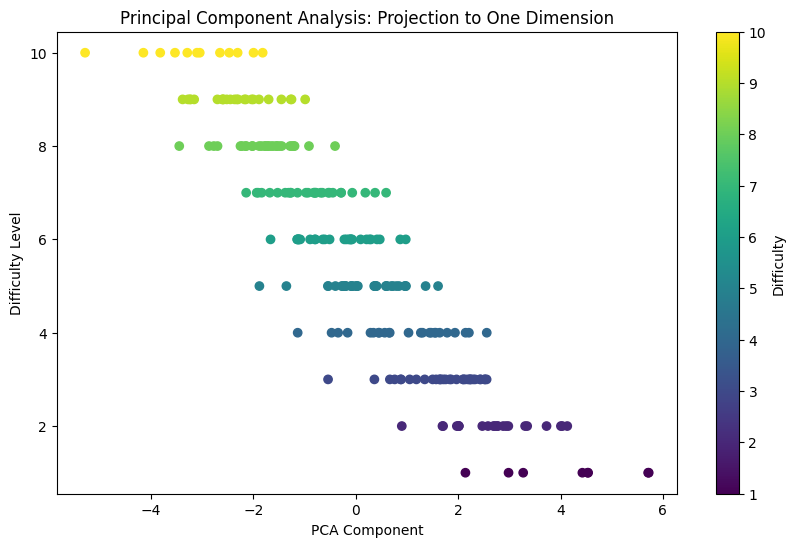

In [ ]:
X = df[featureList]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

df['PCA_Component'] = X_pca.squeeze()

plt.figure(figsize=(10, 6))
plt.scatter(X_pca, y, c=y.Difficulty, cmap='viridis')
plt.xlabel('PCA Component')
plt.ylabel('Difficulty Level')
plt.title('Principal Component Analysis: Projection to One Dimension')
plt.colorbar(label='Difficulty')
plt.show()

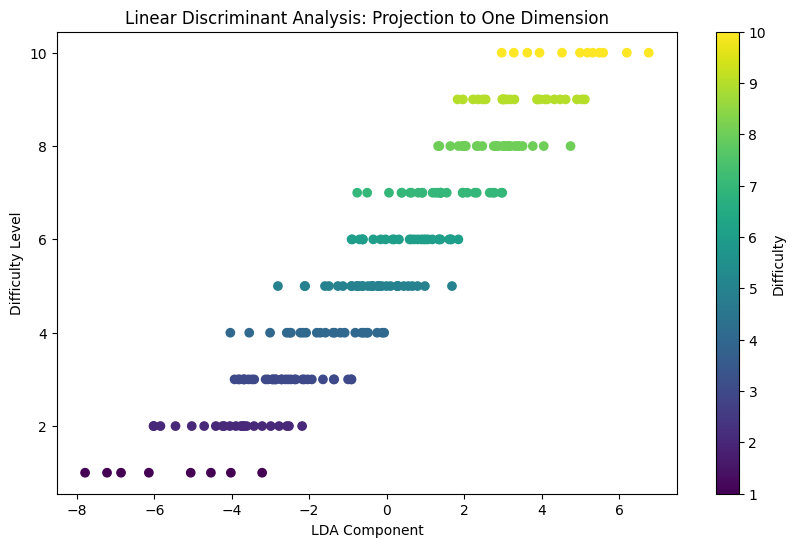

In [ ]:
X = df[featureList]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y_encoded)

df['LDA_Component'] = X_lda.squeeze()

X_lda = df['LDA_Component']
y_lda = df[targetFeature]

plt.figure(figsize=(10, 6))
plt.scatter(X_lda, y_lda, c=y.Difficulty, cmap='viridis')
plt.xlabel('LDA Component')
plt.ylabel('Difficulty Level')
plt.title('Linear Discriminant Analysis: Projection to One Dimension')
plt.colorbar(label='Difficulty')
plt.show()


In [ ]:
feature_weighting = pd.DataFrame(lda.coef_, columns=X.columns, index=sorted(y.Difficulty.unique()))
feature_weighting['MaxInfluence'] = feature_weighting[X.columns].apply(max_abs_column_name, axis=1)
feature_weighting['MinInfluence'] = feature_weighting[X.columns].apply(min_abs_column_name, axis=1)

feature_weighting

NoteDensity  AverageTimeDifference  HighNoteDensity2s     d1min       cdw  \
1      0.497214              12.460283          -4.064727  2.721784  0.959488   
2     -1.617379               6.337512          -4.015279  0.363121  0.074250   
3     -3.614091               0.764445          -3.278513  0.159374 -0.123783   
4     -3.935492              -1.641047          -2.229483  0.158730 -0.040968   
5     -2.422735              -2.463206          -1.149607 -0.373664 -0.412193   
6     -0.815251              -2.422569           0.139592  0.118413 -0.052254   
7      1.246403              -2.010008           1.076070 -0.445671 -0.544711   
8      3.506038              -1.177847           3.289673 -0.436011 -0.013832   
9      4.701221              -0.559697           4.517407 -0.165837  0.613390   
10     8.516755               2.238443           7.160194 -0.095772  0.978499   

             MaxInfluence MinInfluence  
1   AverageTimeDifference  NoteDensity  
2   AverageTimeDifference          cdw  
3             NoteDensity          cdw  
4             NoteDensity          cdw  
5   AverageTimeDifference        d1min  
6   AverageTimeDifference          cdw  
7   AverageTimeDifference        d1min  
8             NoteDensity          cdw  
9             NoteDensity        d1min  
10            NoteDensity        d1min

# Model

In [ ]:
df.loc[49][['SongName', 'Difficulty', *featureList]]

SongName                  Iridium
Difficulty                      7
NoteDensity              4.010087
AverageTimeDifference    0.293967
cdw                         409.5
HighNoteDensity2s            11.0
d1Q0.4                   0.234375
Name: 49, dtype: object

In [ ]:
# Here you have the option to reclassify strong outliers.
df.loc[41, 'Difficulty'] = 10
df.loc[53, 'Difficulty'] = 9

## Curr. SVR

In [ ]:
featureList = ["BPM", 'NoteDensity', 'HighNoteDensity2s']

X = df[featureList].values
y = df[targetFeature]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train, X_test, y_train, y_test = X, X, y, y # cross validation is sufficient here

param_grid = {'C': np.linspace(0.01, 100, num=1000)}

# # params by PKBeam
# svm = SVR(epsilon=0.5, C=33.74)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GridSearchCV(estimator=SVR(epsilon=0.5), param_grid=param_grid, cv=5))
])

pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=5, estimator=SVR(epsilon=0.5),
                              param_grid={'C': array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02])}))])

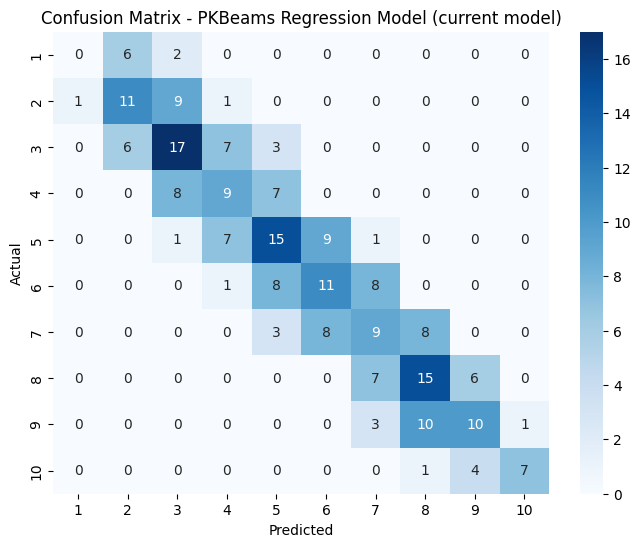

Accuracy     0.433333
Precision    0.428862
Recall       0.433333
F1           0.428357
MCC          0.360277
dtype: float64

In [ ]:
X_test, y_test = X, y
y_linear = pipeline.predict(X_test)

y_pred = []
for prob in y_linear:
    binary_prediction = int(prob + 0.5)
    y_pred.append(binary_prediction)

classes = range(1, 1 + np.max(df[targetFeature].Difficulty.unique()))
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix - PKBeams Regression Model (current model)', cmap=plt.cm.Blues)

pd.Series({
    "Accuracy": metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Recall": metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "F1": metrics.f1_score(y_test, y_pred, average='weighted'),
    "MCC": metrics.matthews_corrcoef(y_test, y_pred)
})

## LDA/PCA 4Dim, SVR

In [ ]:
featureList = ["NoteDensity", "AverageTimeDifference", "cdw", "HighNoteDensity2s", "d1Q0.4"]

X = df[featureList].values
y = df[targetFeature].values.ravel()

param_grid = {'C': np.logspace(-2, 2, num=1000)}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('lda', LDA(n_components=4)),
    ('pca', PCA(n_components=5)),
    ('classifier', GridSearchCV(estimator=SVR(epsilon=0.5), param_grid=param_grid, cv=10))
], verbose=True)

pipeline.fit(X, y)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  41.3s


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('classifier',
                 GridSearchCV(cv=10, estimator=SVR(epsilon=0.5),
                              param_grid={'C': array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02,...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02])}))],
         verbose=True)

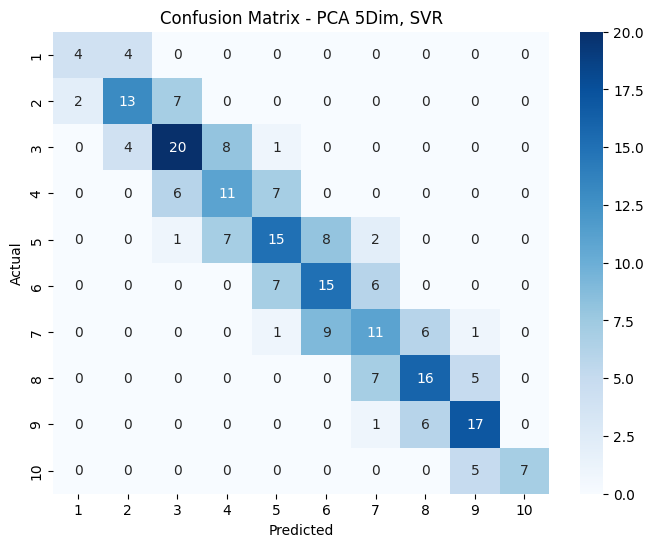

Accuracy     0.537500
Precision    0.548290
Recall       0.537500
F1           0.538910
MCC          0.479304
dtype: float64

In [ ]:
X_test, y_test = X, y
y_linear = pipeline.predict(X_test)

y_pred = []
for prob in y_linear:
    binary_prediction = int(prob + 0.5)
    y_pred.append(binary_prediction)

classes = range(1, 1 + np.max(df[targetFeature].Difficulty.unique()))
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix - PCA 5Dim, SVR', cmap=plt.cm.Blues)

pd.Series({
    "Accuracy": metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Recall": metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "F1": metrics.f1_score(y_test, y_pred, average='weighted'),
    "MCC": metrics.matthews_corrcoef(y_test, y_pred)
})

# Export

In [ ]:
from sklearn2pmml import PMMLPipeline, sklearn2pmml

pmml_pipeline = PMMLPipeline(pipeline.steps)
pmml_pipeline.fit(X, y)

print(pmml_pipeline)

sklearn2pmml(pmml_pipeline, "model.pmml")

PMMLPipeline(steps=[('scaler', StandardScaler()),
       ('pca', PCA(n_components=4)),
       ('classifier', GridSearchCV(cv=10, estimator=SVR(epsilon=0.5),
             param_grid={'C': array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02, 1.12733256e-02, 1.13777413e-02, 1.14831241e-02,
       1.15894830e-02, 1.16968270e-02, 1.18051653e...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02])}))])


In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

input_type = [('input', FloatTensorType([None, len(featureList)]))]

onnx_model = convert_sklearn(pipeline, 'model.onnx', initial_types=input_type)

with open("./model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

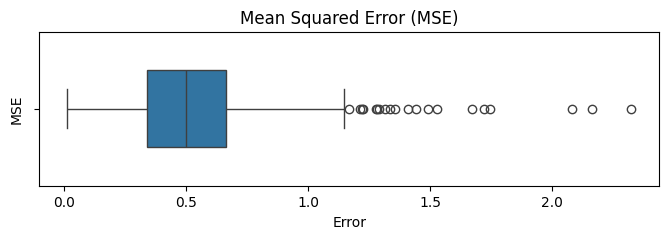

actual  predicted     error
49        7   4.675787  2.324213
91        5   7.164505  2.164505
226       5   2.918087  2.081913
56        9   7.255093  1.744907
154       5   6.721513  1.721513
..      ...        ...       ...
83        8   8.027584  0.027584
117       4   4.026161  0.026161
24        3   2.974903  0.025097
103       4   4.017937  0.017937
64        6   6.013165  0.013165

[240 rows x 3 columns]

In [ ]:
#test model
import onnxruntime as rt
sess = rt.InferenceSession("./model.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
pred_onx = sess.run([output_name], {input_name: X.astype(np.float32)})[0]

predicted_labels = [float(label) for label in pred_onx]
errors = np.abs(y_test - predicted_labels)
df_model_result = pd.DataFrame({"actual": y_test, "predicted": predicted_labels, "error": errors})
df_model_result = df_model_result.sort_values(by="error", ascending=False)

plt.figure(figsize=(8, 2))
sns.boxplot(x='error', data=df_model_result, width=0.5)
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Error')
plt.ylabel('MSE')
plt.show()

df_model_result

In [ ]:
df[featureList].min()

NoteDensity               1.627074
AverageTimeDifference     0.152743
cdw                      78.000000
HighNoteDensity2s         4.925000
d1Q0.4                    0.091463
dtype: float64

In [ ]:
df[featureList].max()

NoteDensity                 7.615101
AverageTimeDifference       0.793388
cdw                      1578.500000
HighNoteDensity2s          25.500000
d1Q0.4                      0.999985
dtype: float64